# Exploratory data analysis



Pandas was updated on 03/04/2023 to version 2.0, which is not compatibile with tsfel. Dowgrade to 1.5.3

In [2]:
!pip install pandas==1.5.3
!pip install tsfel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.0 MB/s eta 0:00:00


## Import and settings

In [3]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [4]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold


# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [5]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

In [6]:
def get_df_action(filepaths_csv, filepaths_meta, action2int=None, delimiter=";"):
    # Load dataframes
    print("Loading data.")
    # Make dataframes
    # Some classes show the output boolean parameter as True rather than true. Fix here
    dfs_meta = list()
    for filepath in filepaths_meta:
        df_m = pd.read_csv(filepath, sep=delimiter)
        df_m.str_repr = df_m.str_repr.str.replace('True', 'true')
        df_m['filepath'] = filepath
        dfs_meta.append(df_m)

    df_meta = pd.concat(dfs_meta)
    df_meta.index = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['completed_timestamp'] = pd.to_datetime(df_meta.completed_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['init_timestamp'] = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'),
                                               format="%Y-%m-%dT%H:%M:%S.%f")

    # Eventually reduce number of classes
    # df_meta['str_repr'] = df_meta.str_repr.str.split('=', expand = True,n=1)[0]
    # df_meta['str_repr'] = df_meta.str_repr.str.split('(', expand=True, n=1)[0]

    actions = df_meta.str_repr.unique()
    dfs = [pd.read_csv(filepath_csv, sep=";") for filepath_csv in filepaths_csv]
    df = pd.concat(dfs)

    # Sort columns by name !!!
    df = df.sort_index(axis=1)

    # Set timestamp as index
    df.index = pd.to_datetime(df.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    # Drop useless columns
    columns_to_drop = [column for column in df.columns if "Abb" in column or "Temperature" in column]
    df.drop(["machine_nameKuka Robot_export_active_energy",
             "machine_nameKuka Robot_import_reactive_energy"] + columns_to_drop, axis=1, inplace=True)
    signals = df.columns

    df_action = list()
    for action in actions:
        for index, row in df_meta[df_meta.str_repr == action].iterrows():
            start = row['init_timestamp']
            end = row['completed_timestamp']
            df_tmp = df.loc[start: end].copy()
            df_tmp['action'] = action
            # Duration as string (so is not considered a feature)
            df_tmp['duration'] = str((row['completed_timestamp'] - row['init_timestamp']).total_seconds())
            df_action.append(df_tmp)
    df_action = pd.concat(df_action, ignore_index=True)
    df_action.index = pd.to_datetime(df_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_action = df_action[~df_action.index.duplicated(keep='first')]

    # Drop NaN
    df = df.dropna(axis=0)
    df_action = df_action.dropna(axis=0)

    if action2int is None:
        action2int = dict()
        j = 1
        for label in df_action.action.unique():
            action2int[label] = j
            j += 1

    df_merged = df.merge(df_action[['action']], left_index=True, right_index=True, how="left")
    # print(f"df_merged len: {len(df_merged)}")
    # Where df_merged in NaN Kuka is in idle state
    df_idle = df_merged[df_merged['action'].isna()].copy()
    df_idle['action'] = 'idle'
    df_idle['duration'] = df_action.duration.values.astype(float).mean().astype(str)
    df_action = pd.concat([df_action, df_idle])

    # ile label must be 0 for debug mode
    action2int['idle'] = 0
    return df_action, df, df_meta, action2int



In [7]:
ROOTDIR_DATASET_NORMAL = "/content/drive/MyDrive/Kuka_v1/normal"

filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

Loading data.


In [8]:
print(df_action.columns.values)
print(len(df_action))

['machine_nameKuka Robot_apparent_power' 'machine_nameKuka Robot_current'
 'machine_nameKuka Robot_export_reactive_energy'
 'machine_nameKuka Robot_frequency'
 'machine_nameKuka Robot_import_active_energy'
 'machine_nameKuka Robot_phase_angle' 'machine_nameKuka Robot_power'
 'machine_nameKuka Robot_power_factor'
 'machine_nameKuka Robot_reactive_power' 'machine_nameKuka Robot_voltage'
 'sensor_id1_AccX' 'sensor_id1_AccY' 'sensor_id1_AccZ' 'sensor_id1_AngX'
 'sensor_id1_AngY' 'sensor_id1_AngZ' 'sensor_id1_GyroX' 'sensor_id1_GyroY'
 'sensor_id1_GyroZ' 'sensor_id2_AccX' 'sensor_id2_AccY' 'sensor_id2_AccZ'
 'sensor_id2_AngX' 'sensor_id2_AngY' 'sensor_id2_AngZ' 'sensor_id2_GyroX'
 'sensor_id2_GyroY' 'sensor_id2_GyroZ' 'sensor_id3_AccX' 'sensor_id3_AccY'
 'sensor_id3_AccZ' 'sensor_id3_AngX' 'sensor_id3_AngY' 'sensor_id3_AngZ'
 'sensor_id3_GyroX' 'sensor_id3_GyroY' 'sensor_id3_GyroZ'
 'sensor_id4_AccX' 'sensor_id4_AccY' 'sensor_id4_AccZ' 'sensor_id4_AngX'
 'sensor_id4_AngY' 'sensor_id4_AngZ' 

In [9]:
print(df.columns.values)
print(len(df))

['machine_nameKuka Robot_apparent_power' 'machine_nameKuka Robot_current'
 'machine_nameKuka Robot_export_reactive_energy'
 'machine_nameKuka Robot_frequency'
 'machine_nameKuka Robot_import_active_energy'
 'machine_nameKuka Robot_phase_angle' 'machine_nameKuka Robot_power'
 'machine_nameKuka Robot_power_factor'
 'machine_nameKuka Robot_reactive_power' 'machine_nameKuka Robot_voltage'
 'sensor_id1_AccX' 'sensor_id1_AccY' 'sensor_id1_AccZ' 'sensor_id1_AngX'
 'sensor_id1_AngY' 'sensor_id1_AngZ' 'sensor_id1_GyroX' 'sensor_id1_GyroY'
 'sensor_id1_GyroZ' 'sensor_id2_AccX' 'sensor_id2_AccY' 'sensor_id2_AccZ'
 'sensor_id2_AngX' 'sensor_id2_AngY' 'sensor_id2_AngZ' 'sensor_id2_GyroX'
 'sensor_id2_GyroY' 'sensor_id2_GyroZ' 'sensor_id3_AccX' 'sensor_id3_AccY'
 'sensor_id3_AccZ' 'sensor_id3_AngX' 'sensor_id3_AngY' 'sensor_id3_AngZ'
 'sensor_id3_GyroX' 'sensor_id3_GyroY' 'sensor_id3_GyroZ'
 'sensor_id4_AccX' 'sensor_id4_AccY' 'sensor_id4_AccZ' 'sensor_id4_AngX'
 'sensor_id4_AngY' 'sensor_id4_AngZ' 

In [10]:
print(df_meta.columns.values)
print(len(df_meta))

['id' 'state_id' 'str_repr' 'init_timestamp' 'running_timestamp'
 'completed_timestamp' 'filepath']
947


In [11]:
action2int

{'pickFromPallet(2,2)=[true,1,0]': 1,
 'placeToPallet(1,2)=[true,0]': 2,
 'moveOverPallet(2,1)=[true,0]': 3,
 'moveOverPallet(1,2)=[true,0]': 4,
 'pickFromPallet(1,2)=[true,1,0]': 5,
 'placeToPallet(1,1)=[true,0]': 6,
 'moveOverPallet(1,3)=[true,0]': 7,
 'moveOverPallet(3,1)=[true,0]': 8,
 'pickFromPallet(3,2)=[true,1,0]': 9,
 'placeToPallet(1,3)=[true,0]': 10,
 'moveOverPallet(3,2)=[true,0]': 11,
 'moveOverPallet(2,3)=[true,0]': 12,
 'pickFromPallet(2,2)=[true,2,0]': 13,
 'placeToPallet(2,2)=[true,0]': 14,
 'pickFromPallet(1,2)=[true,2,0]': 15,
 'placeToPallet(2,1)=[true,0]': 16,
 'pickFromPallet(3,2)=[true,2,0]': 17,
 'placeToPallet(2,3)=[true,0]': 18,
 'pickFromPallet(2,2)=[true,3,0]': 19,
 'placeToPallet(3,2)=[true,0]': 20,
 'pickFromPallet(1,2)=[true,3,0]': 21,
 'placeToPallet(3,1)=[true,0]': 22,
 'pickFromPallet(3,2)=[true,3,0]': 23,
 'placeToPallet(3,3)=[true,0]': 24,
 'pickFromPallet(2,2)=[true,4,0]': 25,
 'placeToPallet(4,2)=[true,0]': 26,
 'pickFromPallet(1,2)=[true,4,0]': 27

# End of previous ts and start of next are in same conditions?
> NO, but at least are in idle state for 10s

> Can the discontinuity be interpreted as an anomaly if we merge 4 files? idk, but I think yes


In [12]:
#check if timeseries are "well connected" meaning that passing between one and another is ok


timestamps = [
  '2022-08-11T13:08:45.619094+00:00', #start rec0
  '2022-08-11T13:54:29.519094+00:00', #end rec0
  '2022-08-11T14:33:37.088238+00:00', #start rec2
  '2022-08-11T15:07:41.788238+00:00', #end rec2
  '2022-08-11T15:08:49.662687+00:00', #start rec3
  '2022-08-11T15:48:18.462687+00:00', #end rec3
  '2022-08-11T15:49:42.337221+00:00', #start rec4
  '2022-08-11T16:30:06.037221+00:00' #end rec4
  ]


# Filter for idle actions and timestamps within the list
df_action[(df_action['action'] == 'idle') & (df_action['time'].isin(timestamps))]

#good news: initial and final timestamps are 'idol'
#bad news: is not a continuous time series --> probably passing from one time series to another can be seen as anomaly


machine_nameKuka Robot_apparent_power  \
time                                                             
2022-08-11 13:08:45.619                             166.031647   
2022-08-11 13:54:29.519                             255.349060   
2022-08-11 14:33:37.088                             167.123398   
2022-08-11 15:07:41.788                             285.484894   
2022-08-11 15:08:49.662                             167.686096   
2022-08-11 15:48:18.462                             184.996857   
2022-08-11 15:49:42.337                             167.338196   
2022-08-11 16:30:06.037                             215.164246   

                         machine_nameKuka Robot_current  \
time                                                      
2022-08-11 13:08:45.619                        0.994858   
2022-08-11 13:54:29.519                        1.285978   
2022-08-11 14:33:37.088                        1.059016   
2022-08-11 15:07:41.788                        1.398739   
2022-08-11 15:08:49.662                        0.981954   
2022-08-11 15:48:18.462                        0.896612   
2022-08-11 15:49:42.337                        1.067683   
2022-08-11 16:30:06.037                        1.208536   

                         machine_nameKuka Robot_export_reactive_energy  \
time                                                                     
2022-08-11 13:08:45.619                                    1383.391968   
2022-08-11 13:54:29.519                                    1383.473022   
2022-08-11 14:33:37.088                                    1383.542969   
2022-08-11 15:07:41.788                                    1383.604004   
2022-08-11 15:08:49.662                                    1383.605957   
2022-08-11 15:48:18.462                                    1383.677002   
2022-08-11 15:49:42.337                                    1383.680054   
2022-08-11 16:30:06.037                                    1383.751953   

                         machine_nameKuka Robot_frequency  \
time                                                        
2022-08-11 13:08:45.619                         49.951218   
2022-08-11 13:54:29.519                         50.000000   
2022-08-11 14:33:37.088                         50.000000   
2022-08-11 15:07:41.788                         50.000000   
2022-08-11 15:08:49.662                         50.000000   
2022-08-11 15:48:18.462                         49.951218   
2022-08-11 15:49:42.337                         50.000000   
2022-08-11 16:30:06.037                         49.951218   

                         machine_nameKuka Robot_import_active_energy  \
time                                                                   
2022-08-11 13:08:45.619                                  1618.831055   
2022-08-11 13:54:29.519                                  1618.975952   
2022-08-11 14:33:37.088                                  1619.090942   
2022-08-11 15:07:41.788                                  1619.197021   
2022-08-11 15:08:49.662                                  1619.198975   
2022-08-11 15:48:18.462                                  1619.322021   
2022-08-11 15:49:42.337                                  1619.324951   
2022-08-11 16:30:06.037                                  1619.451050   

                         machine_nameKuka Robot_phase_angle  \
time                                                          
2022-08-11 13:08:45.619                          319.619415   
2022-08-11 13:54:29.519                          333.094177   
2022-08-11 14:33:37.088                          319.195862   
2022-08-11 15:07:41.788                          334.507080   
2022-08-11 15:08:49.662                          318.913055   
2022-08-11 15:48:18.462                          331.053101   
2022-08-11 15:49:42.337                          319.310944   
2022-08-11 16:30:06.037                          329.069916   

                         machine_nameKuka Robot_power  \
time        

We will leverage [Time Series Feature Extraction Library (TSFEL)](https://tsfel.readthedocs.io/en/latest/), to extract features from time series data.

In [13]:


def get_windowed_data(root_path="/content/drive/MyDrive/Kuka_v1/", period='0.1', window_size=40, stride=1, train=True):
    """
    -period (str in s) in ['1.0','0.1','0.01','0.05']
    -window_size = n input samples in each window (int)
    -stride = n moving position over time series datapoint (int)



    return window over all train/test timeseries,
    non contiguous timeseries (from different dataset) are handled
    avoiding overlapping (a window over 2 different timeseries data is not possible)
    """

    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)


    assert window_size > 0, "at least 1 sample in each window is required"
    assert stride > 0, "moving window must move of at least 1 sample"
    assert window_size-stride >= 0, "why you are discarding precious timeseries data?"


    overlap = (window_size-stride)/window_size

    window_splits = []

    if train:

        collisions_corr = None

        filepath_csv = [os.path.join(root_path, f"normal/rec{r}_20220811_rbtc_{period}s.csv") for r in [0, 2, 3, 4]]
        filepath_meta = [os.path.join(root_path, f"normal/rec{r}_20220811_rbtc_{period}s.metadata") for r in [0, 2, 3, 4]]

        for i in range(4):
            #get one csv file at a time, discard incorrect (cross-file) time windows
            #--> start from first of at least window_size size)
            df_action, _, _, _ = get_df_action([filepath_csv[i],], [filepath_meta[i],])
            window_splits.extend(tsfel.utils.signal_processing.signal_window_splitter(df_action.copy(), window_size, overlap))

    else:

        collisions = pd.read_excel(os.path.join(root_path, "collisions/20220811_collisions_timestamp.xlsx"))
        #timestamp of collision corrected
        collisions_corr = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')


        filepath_csv = [os.path.join(root_path, f"collisions/rec{r}_collision_20220811_rbtc_{period}s.csv") for r in [1, 5]]
        filepath_meta = [os.path.join(root_path, f"collisions/rec{r}_collision_20220811_rbtc_{period}s.metadata") for r in [1, 5]]

        for i in range(2):
            #get one csv file at a time, discard incorrect (cross-file) time windows
            #--> start from first of at least window_size size)
            df_action, _, _, _ = get_df_action([filepath_csv[i],], [filepath_meta[i],]) #get partial label
            window_splits.extend(tsfel.utils.signal_processing.signal_window_splitter(df_action.copy(), window_size, overlap))

    df_action_tot, _, _, _ = get_df_action(filepath_csv, filepath_meta)

    return window_splits, df_action_tot, collisions_corr

ROOTDIR_KUKA = "/content/drive/MyDrive/Kuka_v1"

window_splits_train, df_action_train, _ = get_windowed_data(ROOTDIR_KUKA) # KukaV1 folder
window_splits_test, df_action_test, collisions_corr_test = get_windowed_data(ROOTDIR_KUKA, train=False)

Loading data.
Loading data.
Loading data.
Loading data.
Loading data.
Loading data.
Loading data.
Loading data.


In [14]:
for i,el in enumerate(collisions_corr_test):
  print(i)
  print(el)

0
2022-08-11 14:02:17.450000
1
2022-08-11 14:02:21.460000
2
2022-08-11 14:02:28.320000
3
2022-08-11 14:02:31.420000
4
2022-08-11 14:02:45.770000
5
2022-08-11 14:02:49.660000
6
2022-08-11 14:02:57.490000
7
2022-08-11 14:02:59.390000
8
2022-08-11 14:03:56.960000
9
2022-08-11 14:03:58.700000
10
2022-08-11 14:04:09.870000
11
2022-08-11 14:04:12.210000
12
2022-08-11 14:04:23.030000
13
2022-08-11 14:04:26.750000
14
2022-08-11 14:04:38.700000
15
2022-08-11 14:04:41.290000
16
2022-08-11 14:04:59.980000
17
2022-08-11 14:05:02.690000
18
2022-08-11 14:05:24.370000
19
2022-08-11 14:05:28.450000
20
2022-08-11 14:12:46.120000
21
2022-08-11 14:12:50.590000
22
2022-08-11 14:12:59.320000
23
2022-08-11 14:13:03.370000
24
2022-08-11 14:13:23.940000
25
2022-08-11 14:13:27.160000
26
2022-08-11 14:14:31.680000
27
2022-08-11 14:14:36.710000
28
2022-08-11 14:14:41.650000
29
2022-08-11 14:14:43.260000
30
2022-08-11 14:15:48.530000
31
2022-08-11 14:15:52.430000
32
2022-08-11 14:17:04.230000
33
2022-08-11 14:17:

In [15]:
import matplotlib.pyplot as plt

def get_df_anomaly(df, collisions):

    start = None

    mean = 0.0

    df_anomaly = df

    df_anomaly['anomaly'] = 0
    df_anomaly['time'] = pd.to_datetime(df.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")

    count = 0
    for i,anomaly in enumerate(collisions):
        if i%2==0:
            start = anomaly
        else:
            mean += (anomaly - start).total_seconds()/(len(collisions)/2)
            for index, row in df_anomaly.iterrows():
                if ( start <= row['time'] <= anomaly ):
                    count += 1
                    df_anomaly['anomaly'][index] = 1


    print(f"avg duration of anomaly: {mean} s")
    print(f"total anomaly timestamps: {count}")

    return df_anomaly



df_anomaly = get_df_anomaly(df_action_test, collisions_corr_test)


<ipython-input-15-6517c63ffabd>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomaly['anomaly'][index] = 1


avg duration of anomaly: 3.391568627450981 s
total anomaly timestamps: 1736


In [16]:
df_anomaly

machine_nameKuka Robot_apparent_power  \
time                                                             
2022-08-11 14:02:00.444                             164.585693   
2022-08-11 14:02:00.544                             164.585693   
2022-08-11 14:02:00.644                             164.585693   
2022-08-11 14:02:00.744                             164.760590   
2022-08-11 14:02:00.844                             164.760590   
...                                                        ...   
2022-08-11 17:10:57.977                             188.499969   
2022-08-11 17:10:58.077                             188.499969   
2022-08-11 17:10:58.177                             188.499969   
2022-08-11 17:10:58.277                             188.499969   
2022-08-11 17:10:58.377                             188.499969   

                         machine_nameKuka Robot_current  \
time                                                      
2022-08-11 14:02:00.444                        1.064232   
2022-08-11 14:02:00.544                        1.064232   
2022-08-11 14:02:00.644                        1.064232   
2022-08-11 14:02:00.744                        1.042743   
2022-08-11 14:02:00.844                        1.042743   
...                                                 ...   
2022-08-11 17:10:57.977                        1.094982   
2022-08-11 17:10:58.077                        1.094982   
2022-08-11 17:10:58.177                        1.094982   
2022-08-11 17:10:58.277                        1.094982   
2022-08-11 17:10:58.377                        1.094982   

                         machine_nameKuka Robot_export_reactive_energy  \
time                                                                     
2022-08-11 14:02:00.444                                    1383.487061   
2022-08-11 14:02:00.544                                    1383.487061   
2022-08-11 14:02:00.644                                    1383.487061   
2022-08-11 14:02:00.744                                    1383.487061   
2022-08-11 14:02:00.844                                    1383.487061   
...                                                                ...   
2022-08-11 17:10:57.977                                    1383.824951   
2022-08-11 17:10:58.077                                    1383.824951   
2022-08-11 17:10:58.177                                    1383.824951   
2022-08-11 17:10:58.277                                    1383.824951   
2022-08-11 17:10:58.377                                    1383.824951   

                         machine_nameKuka Robot_frequency  \
time                                                        
2022-08-11 14:02:00.444                         50.000000   
2022-08-11 14:02:00.544                         50.000000   
2022-08-11 14:02:00.644                         50.000000   
2022-08-11 14:02:00.744                         50.000000   
2022-08-11 14:02:00.844                         50.000000   
...                                                   ...   
2022-08-11 17:10:57.977                         50.048878   
2022-08-11 17:10:58.077                         50.048878   
2022-08-11 17:10:58.177                         50.048878   
2022-08-11 17:10:58.277                         50.000000   
2022-08-11 17:10:58.377                         50.000000   

                         machine_nameKuka Robot_import_active_energy  \
time                                                                   
2022-08-11 14:02:00.444                                  1618.994995   
2022-08-11 14:02:00.544                                  1618.994995   
2022-08-11 14:02:00.644                                  1618.994995   
2022-08-11 14:02:00.744                                  1618.994995   
2022-08-11 14:02:00.844                                  1618.994995   
...                                                              ...   
2022-08-11 17:10:57.977                                  1619.562

In [17]:
(df_anomaly['anomaly']==1).any()

True

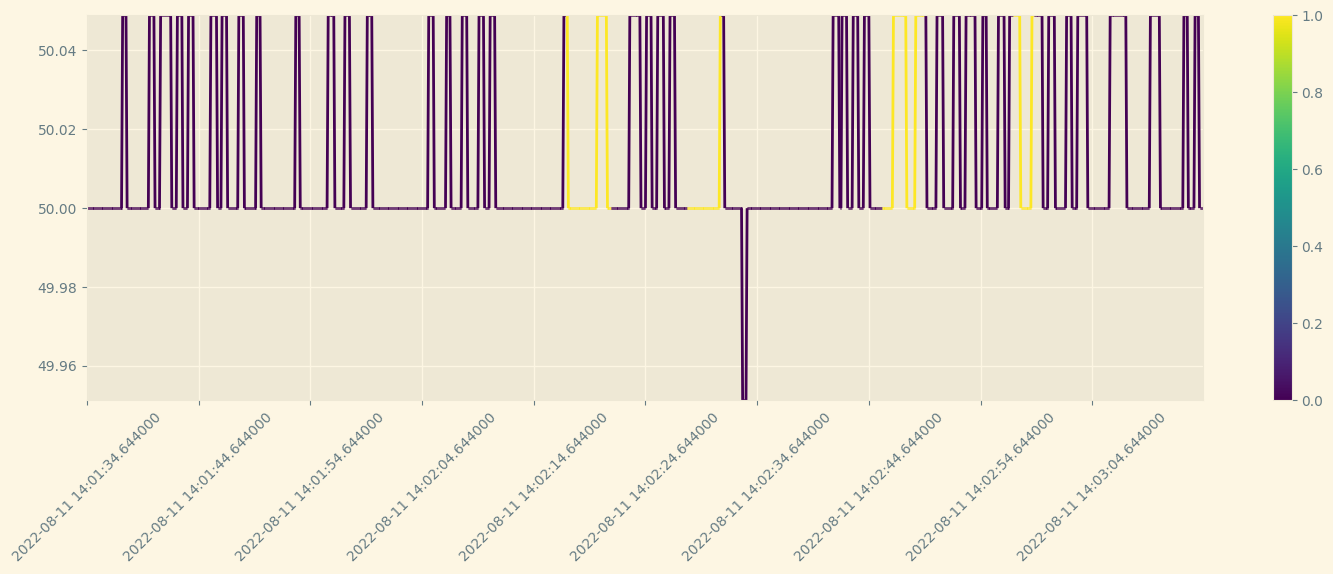

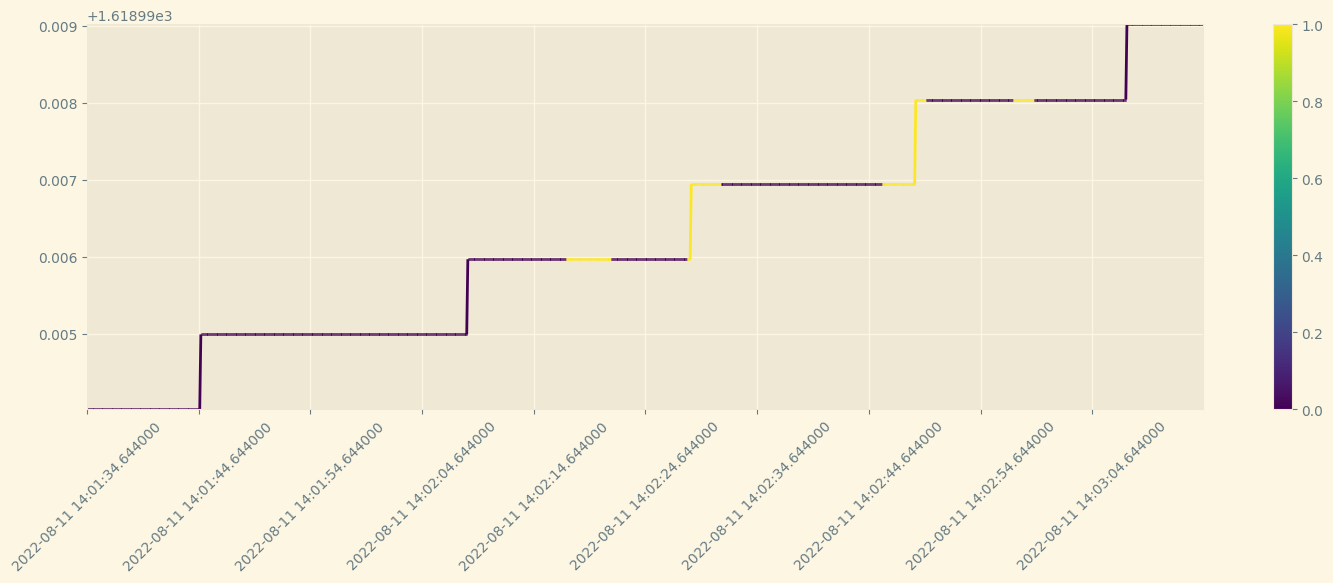

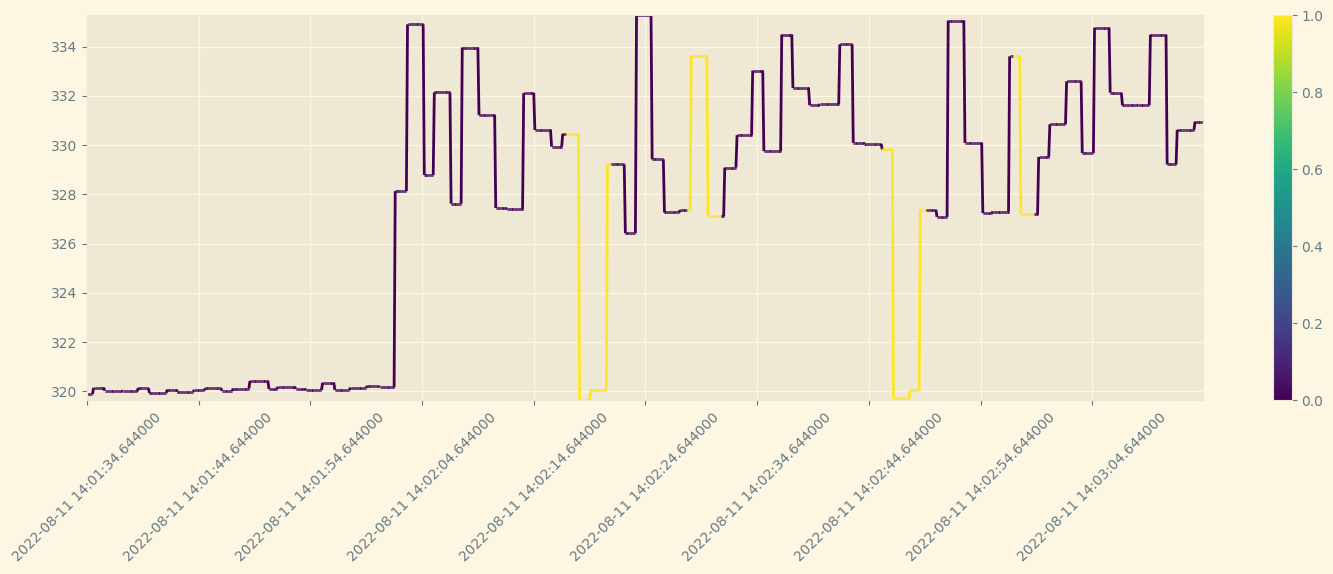

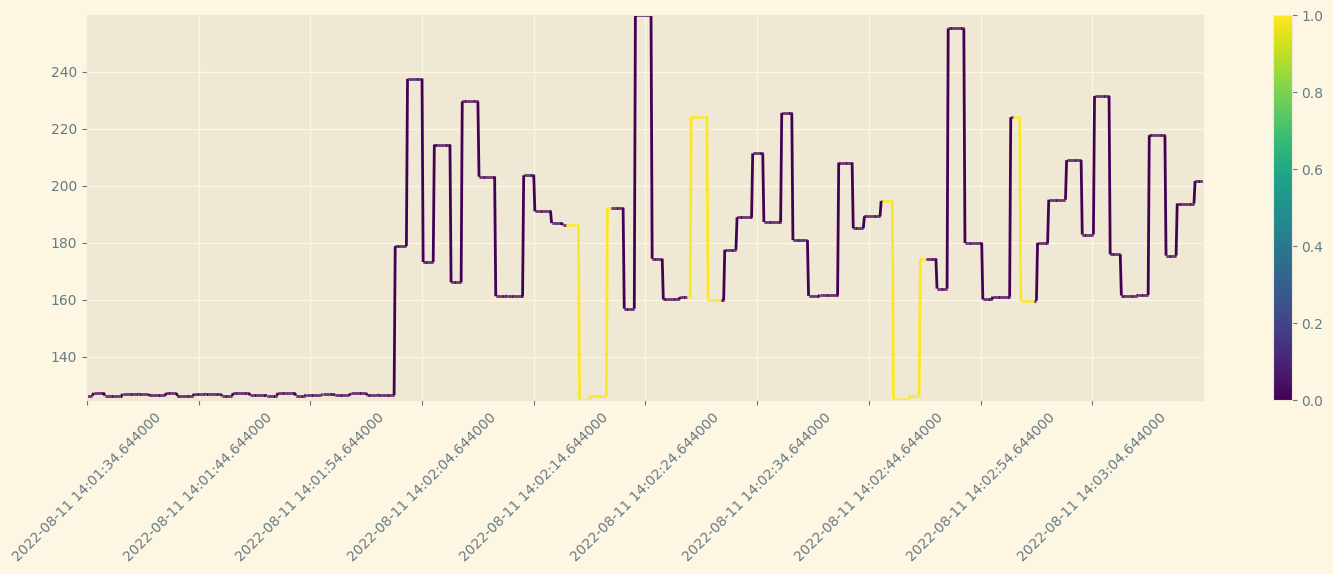

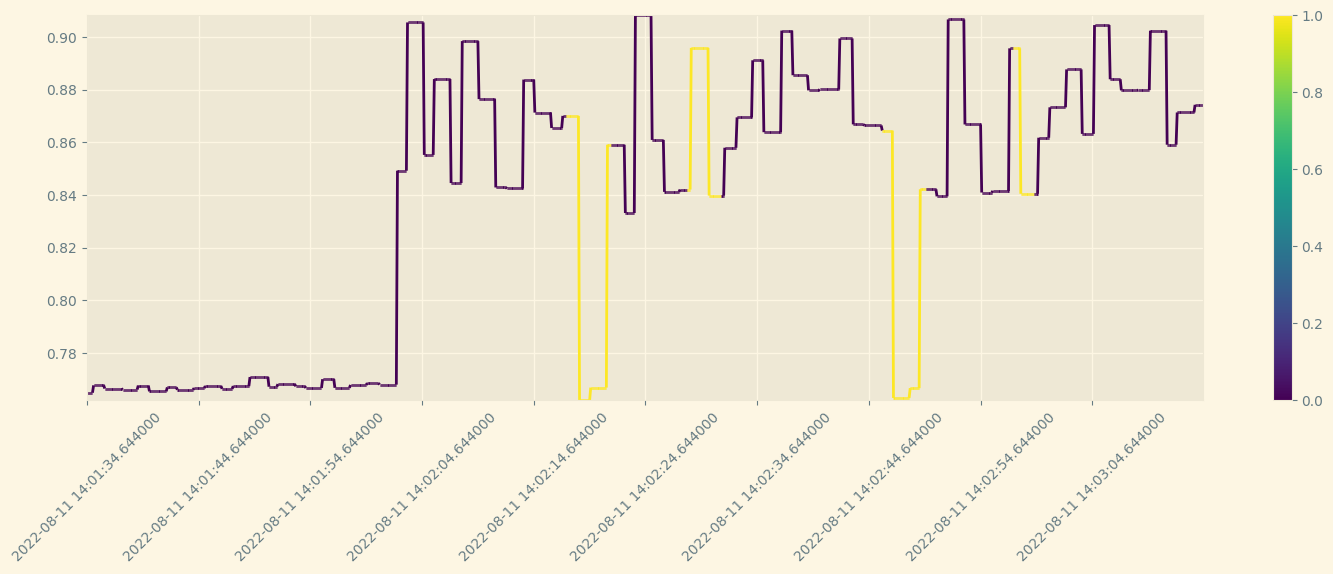

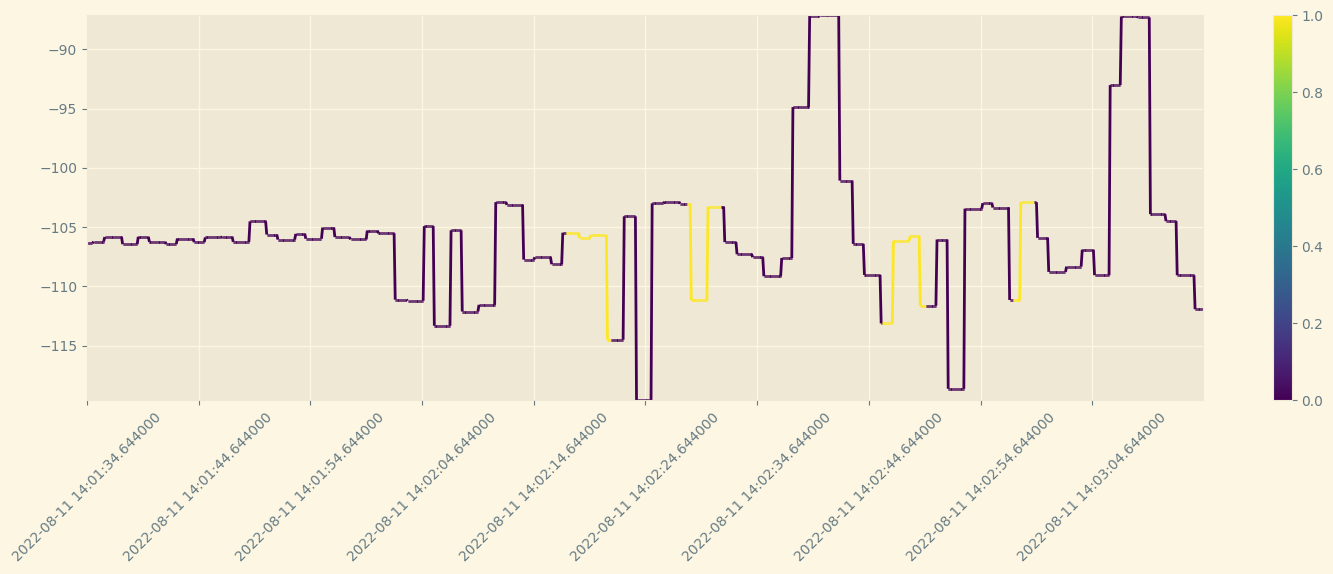

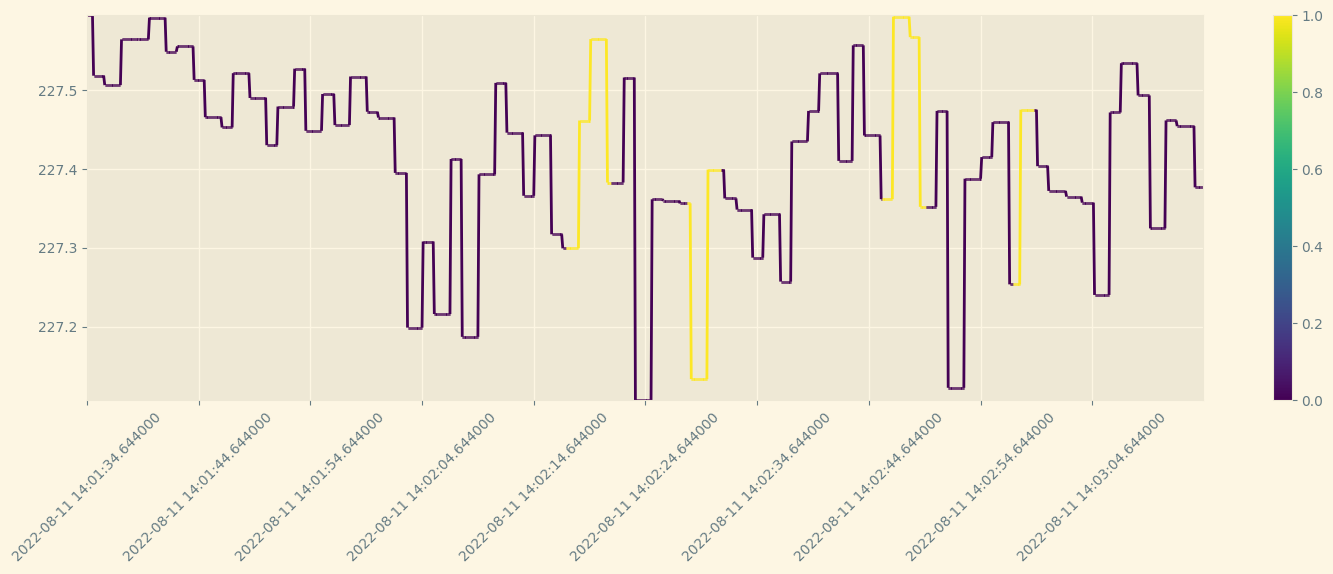

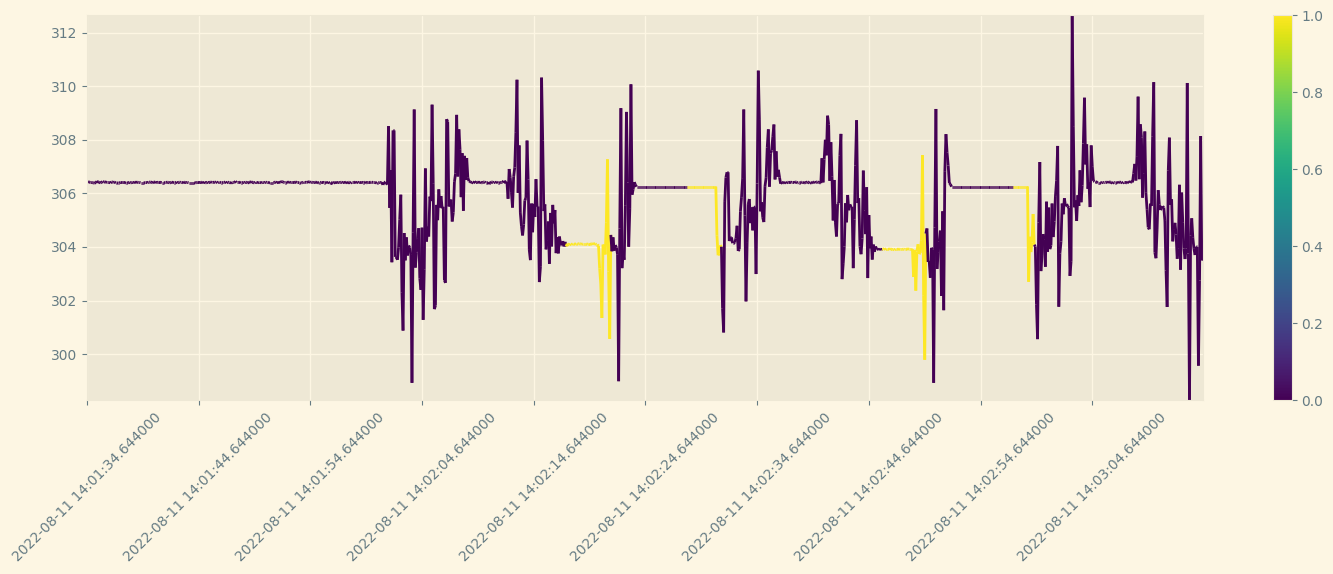

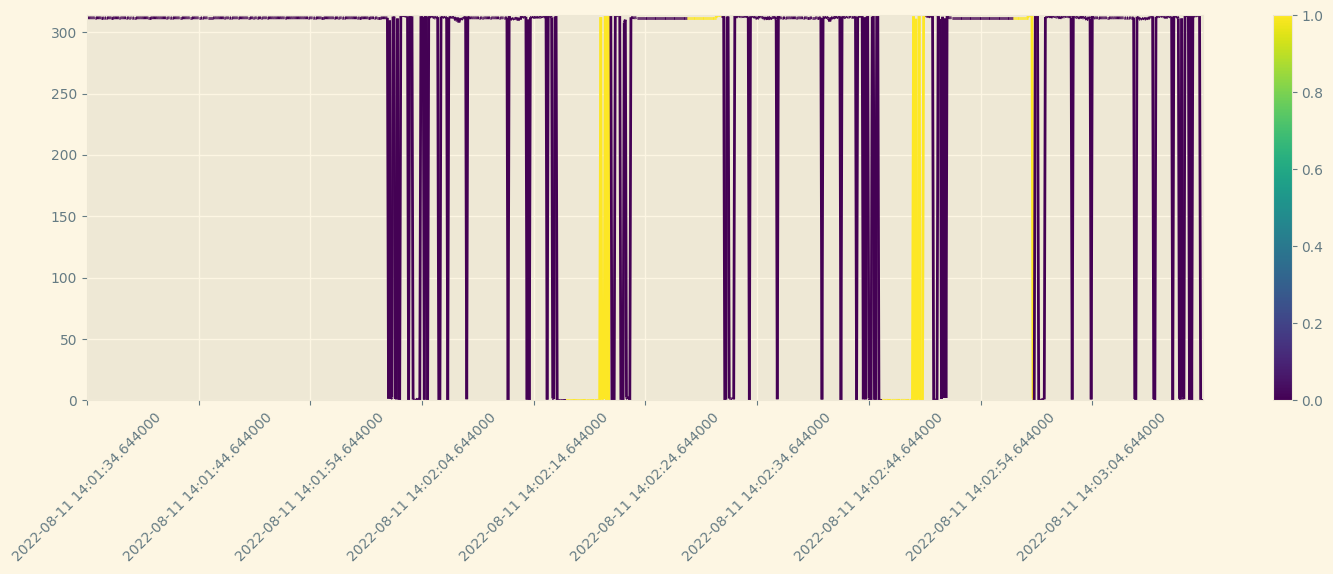

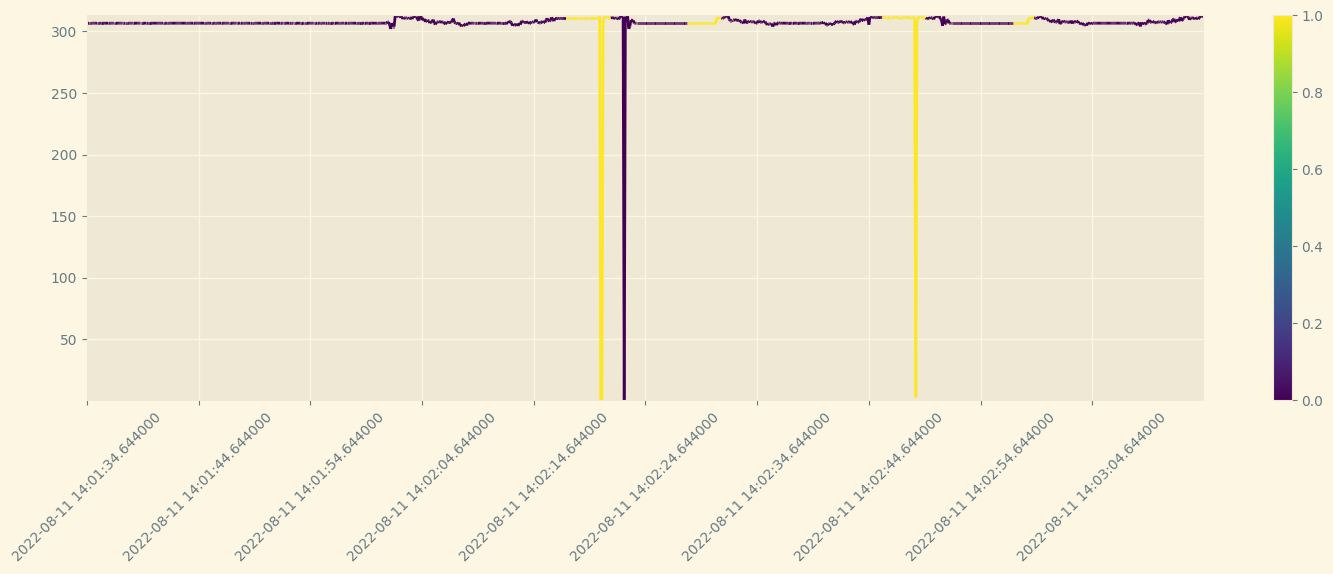

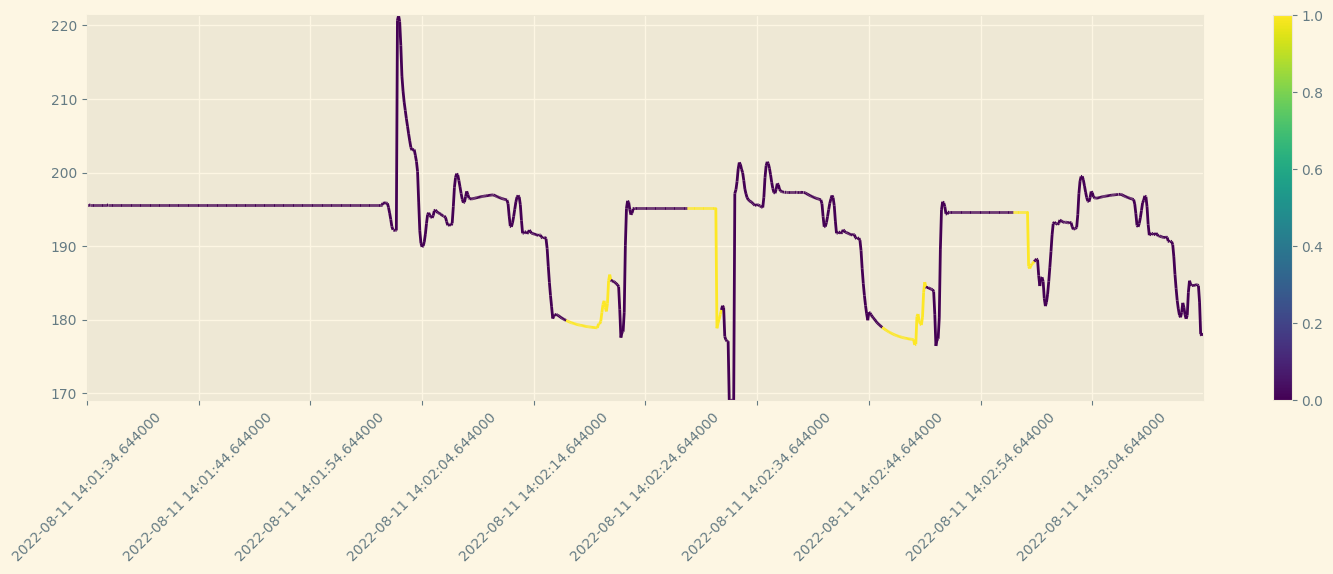

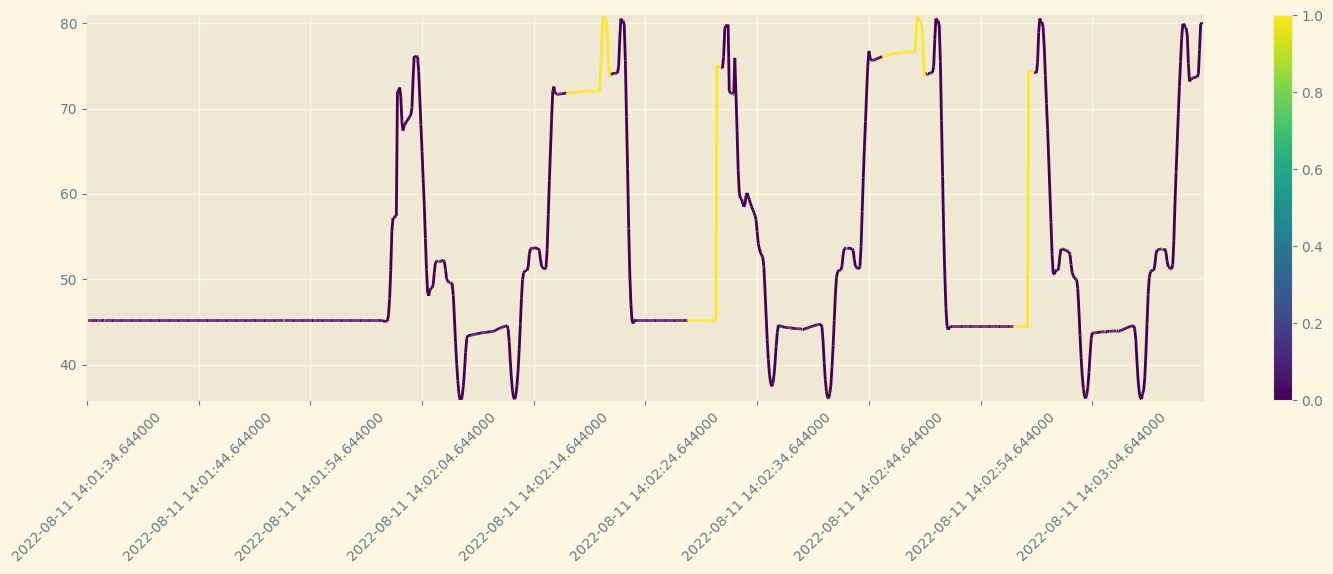

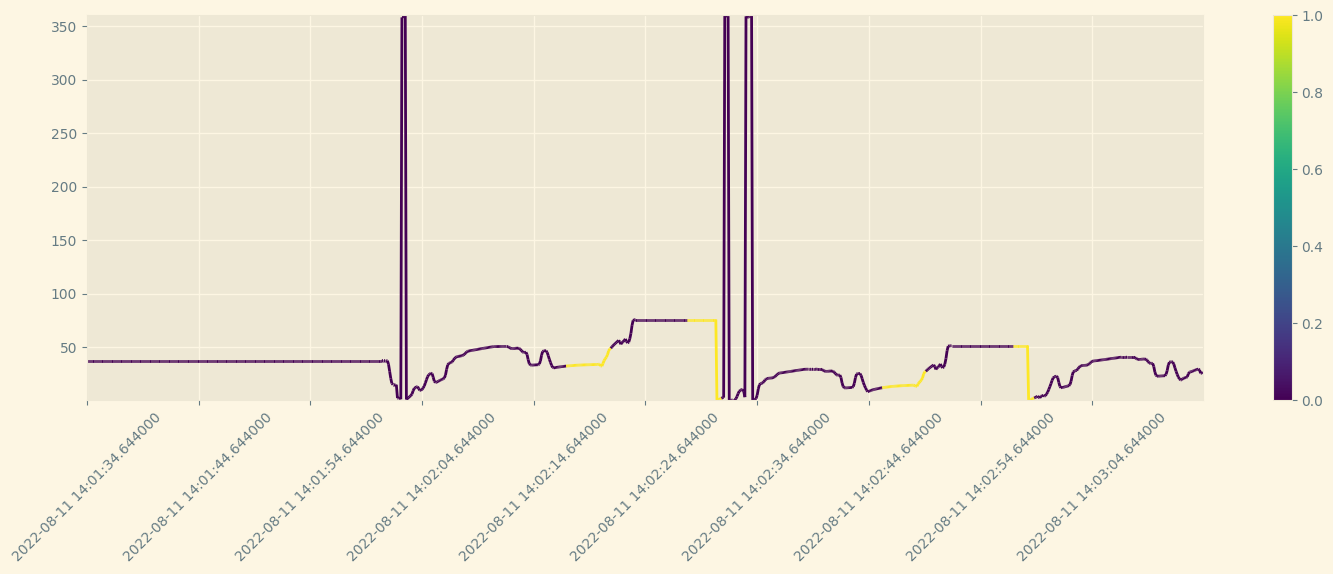

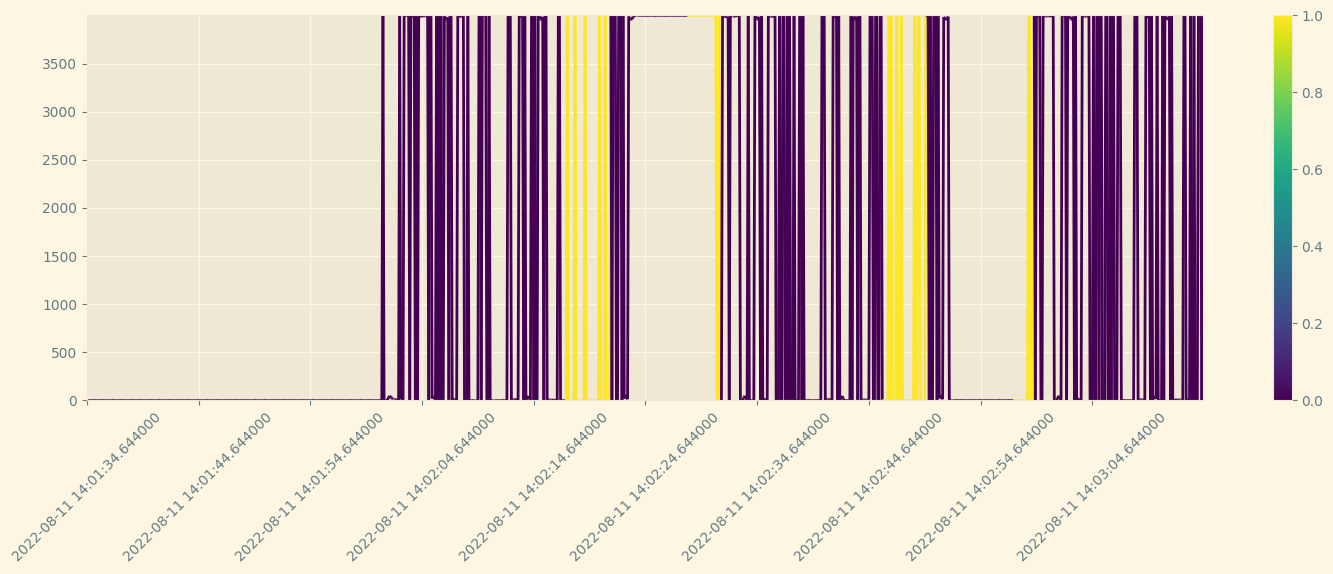

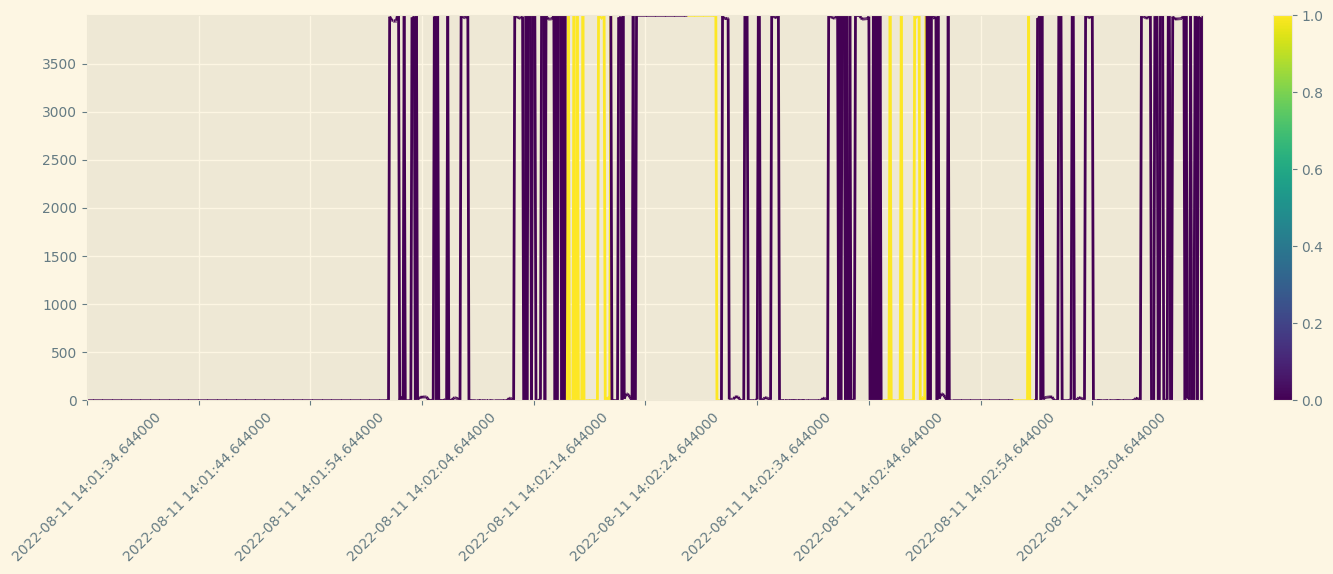

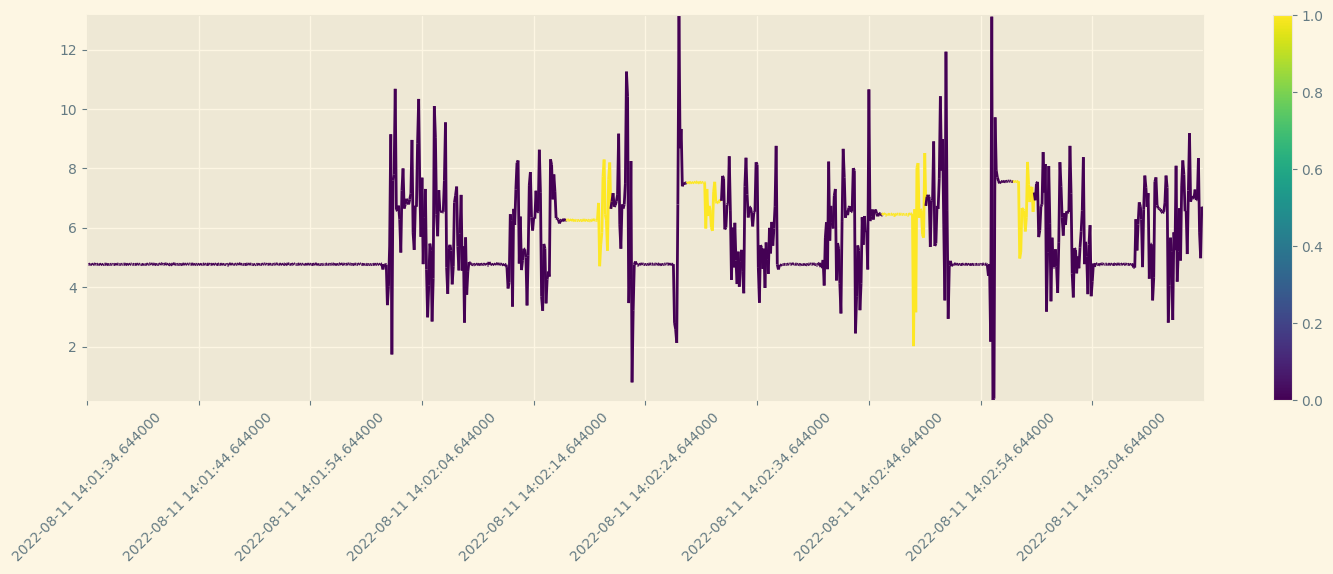

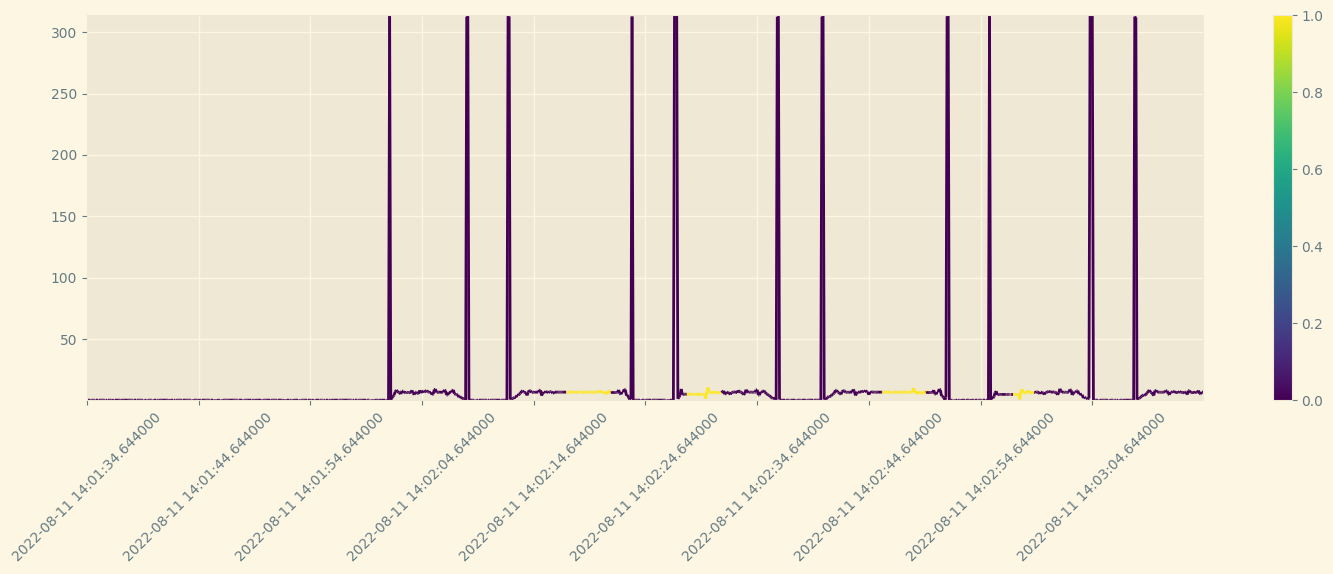

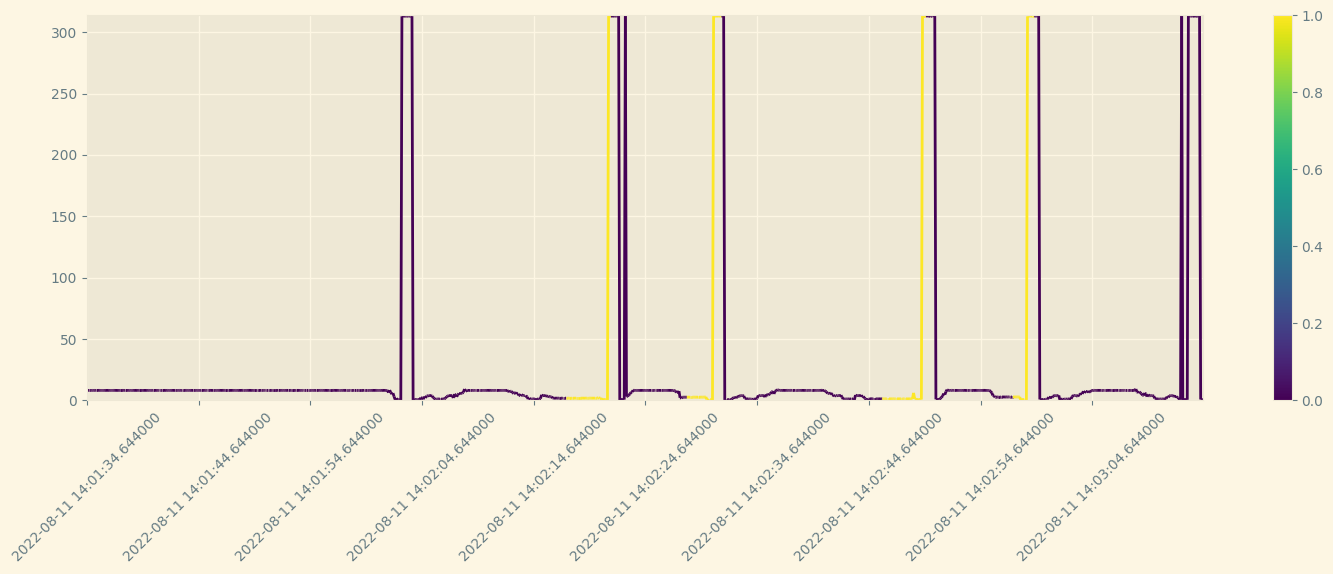

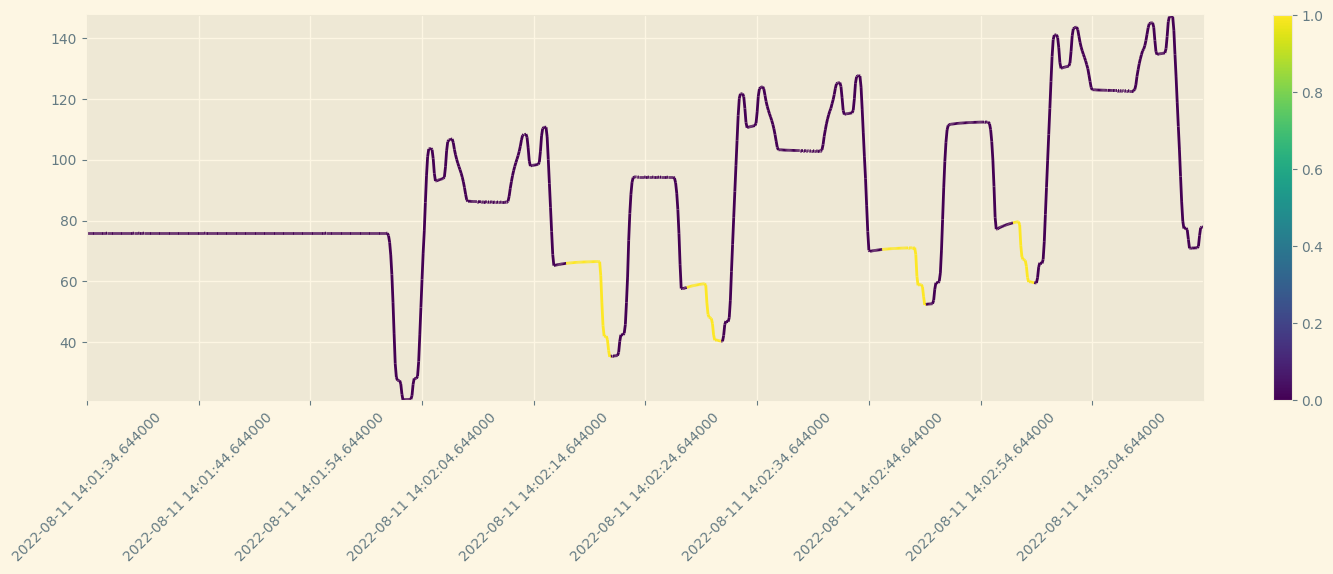

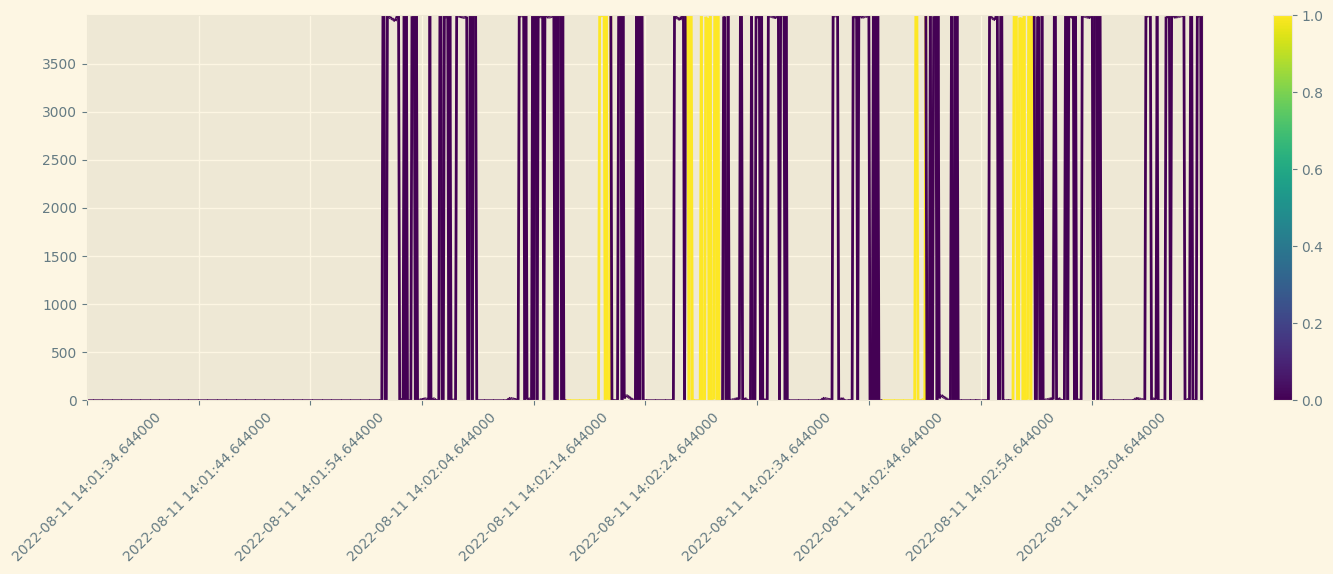

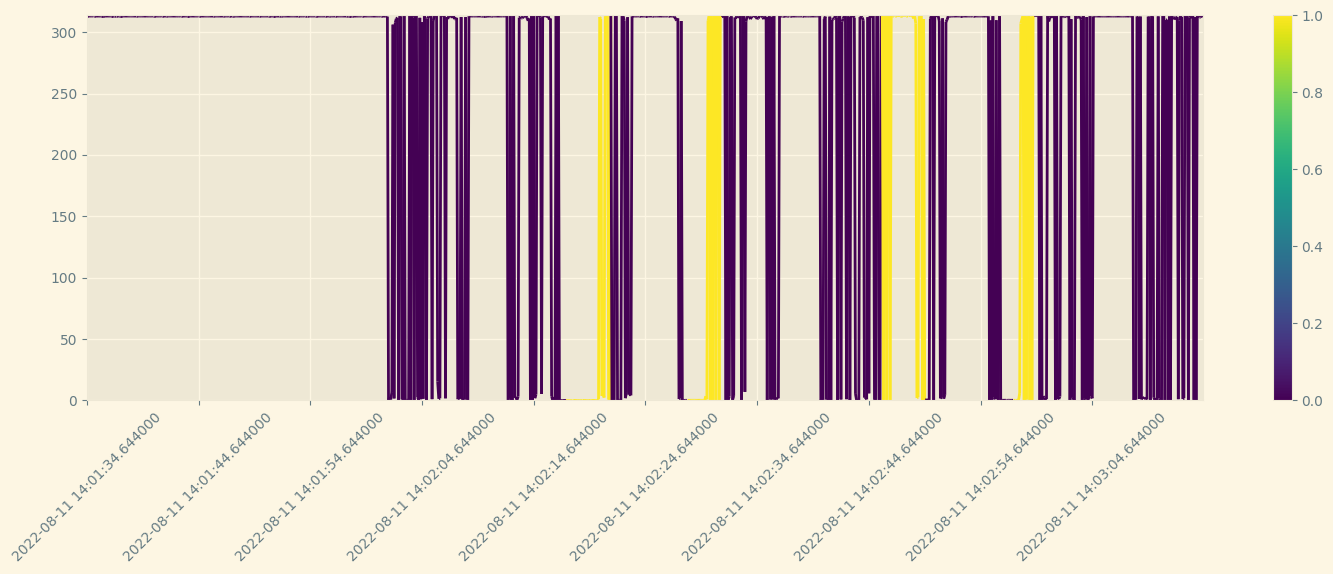

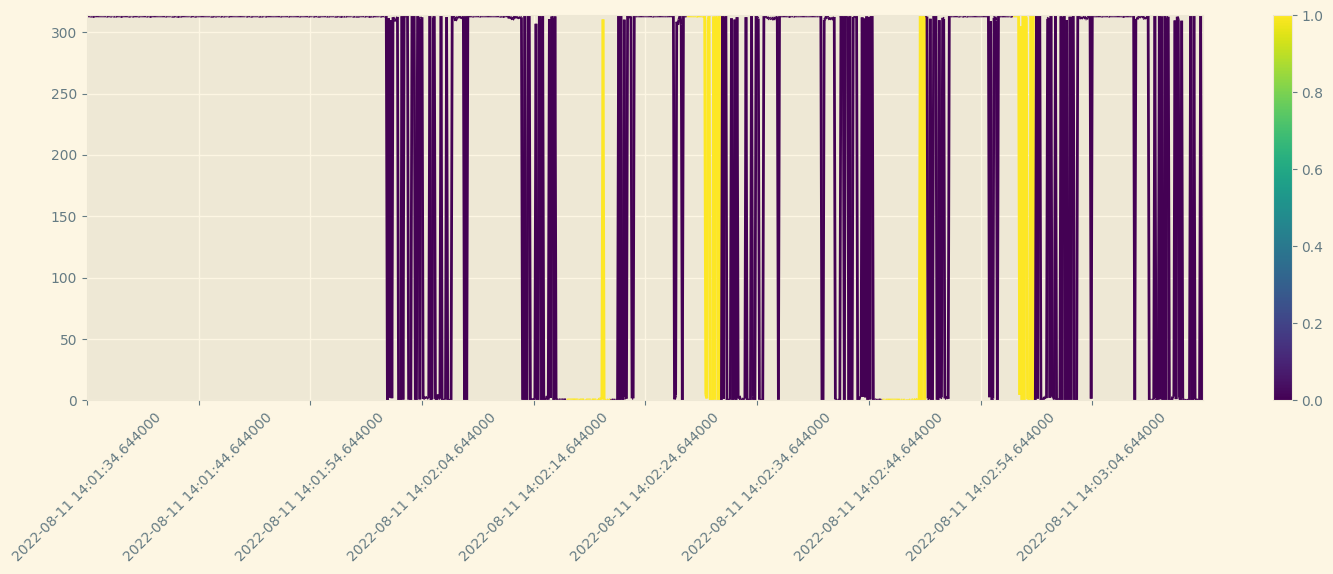

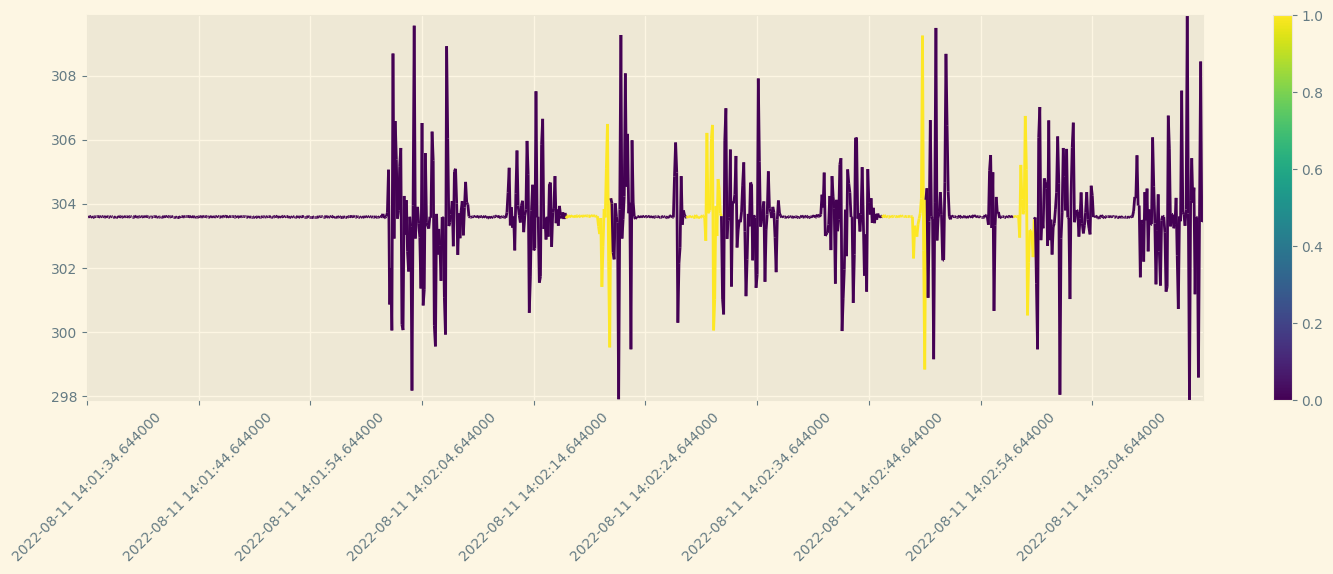

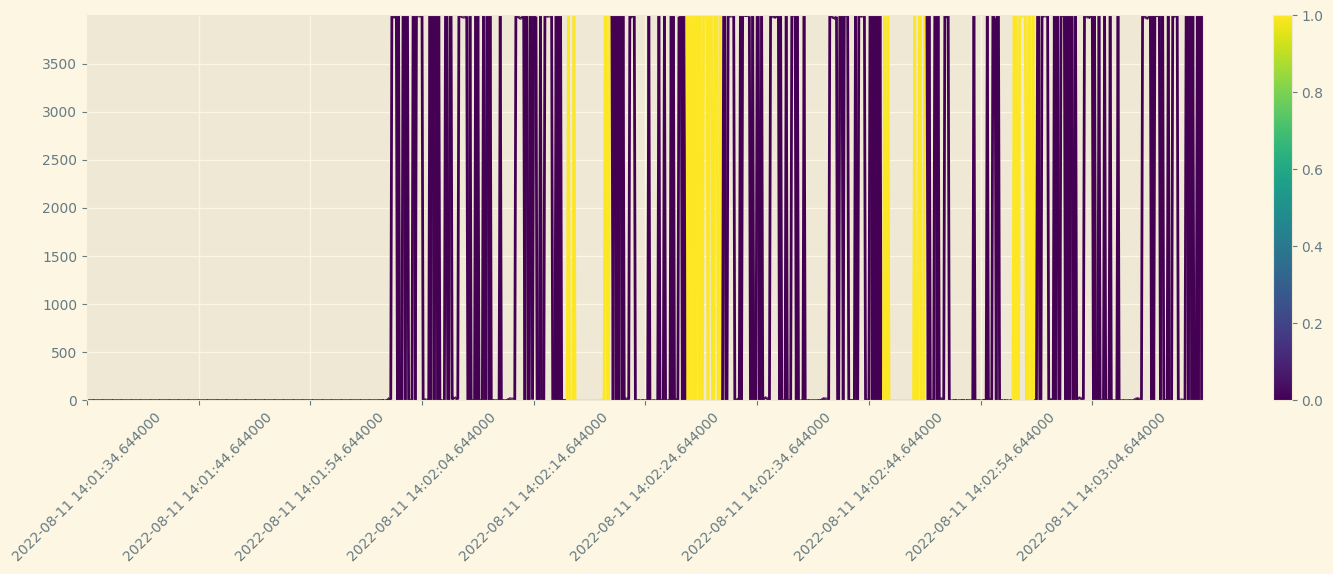

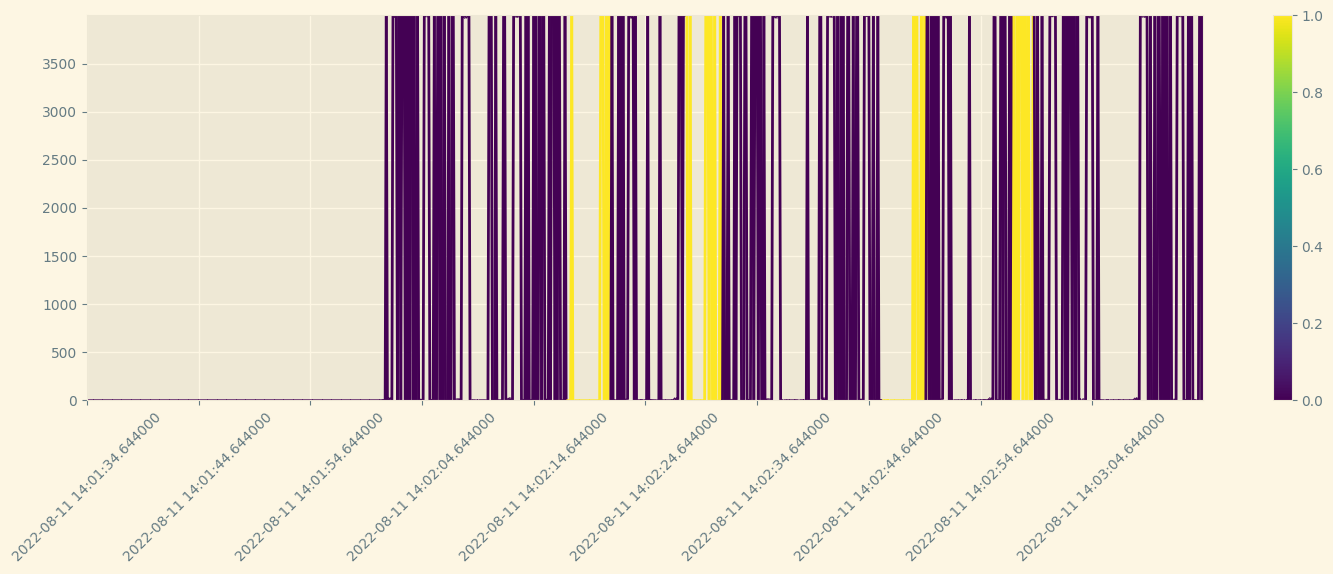

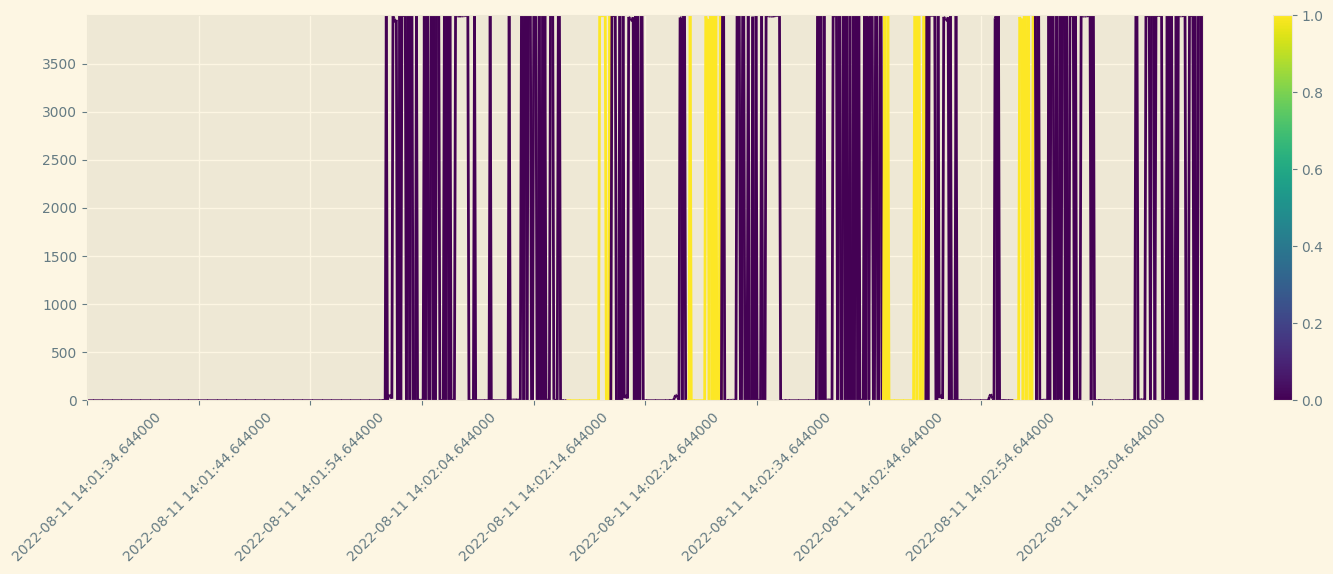

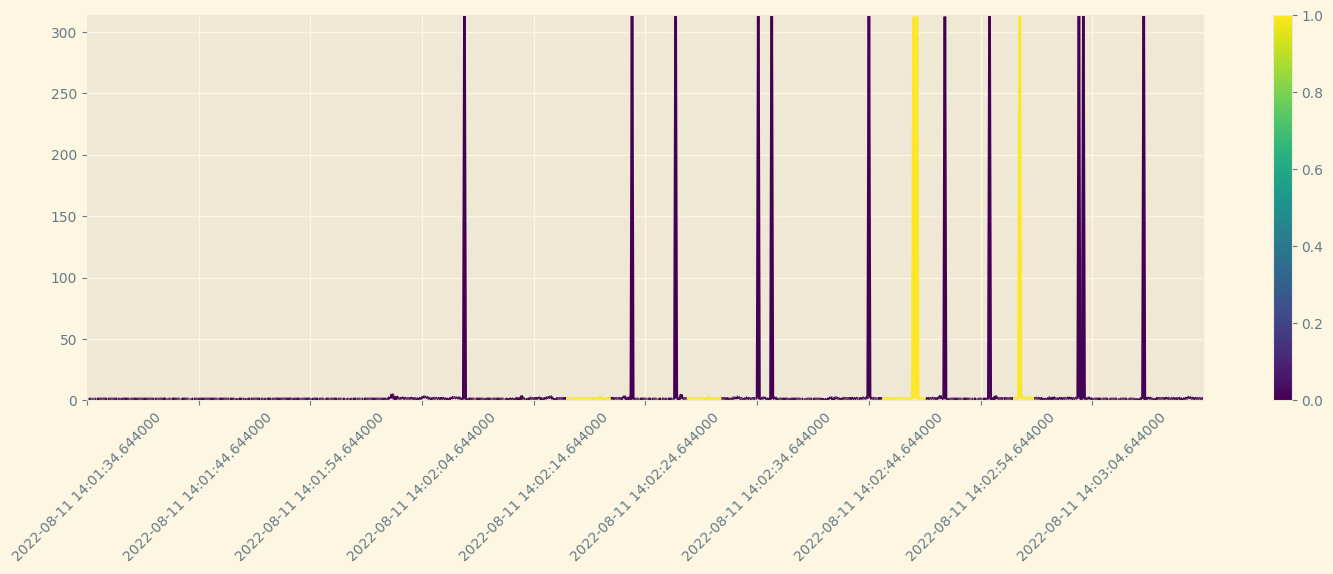

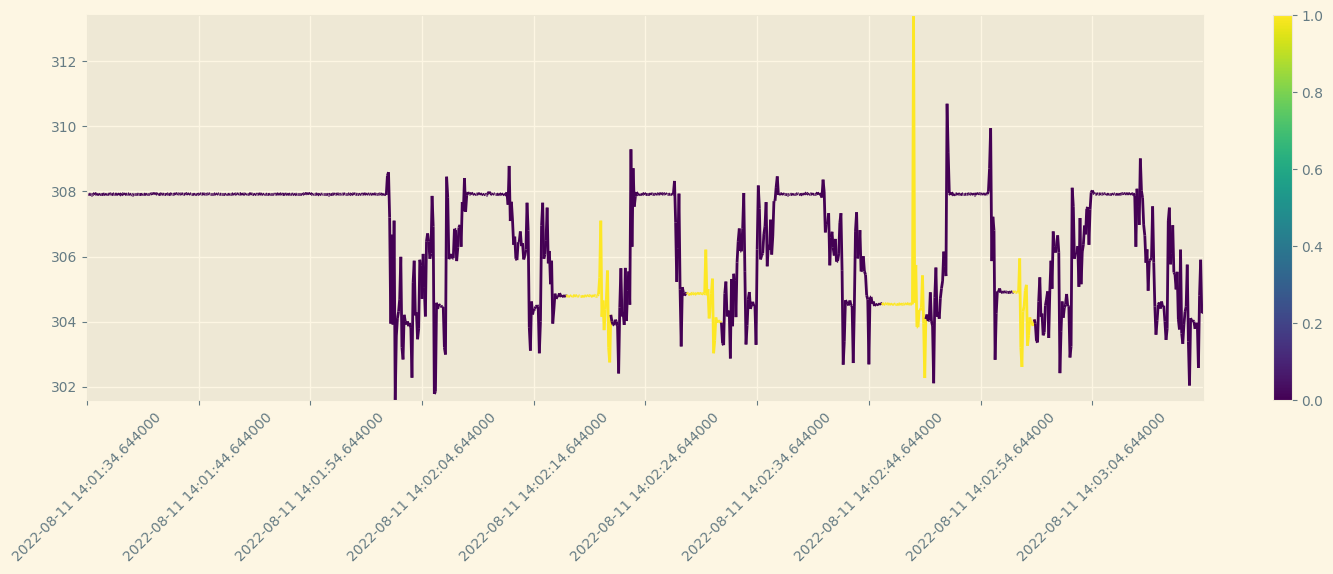

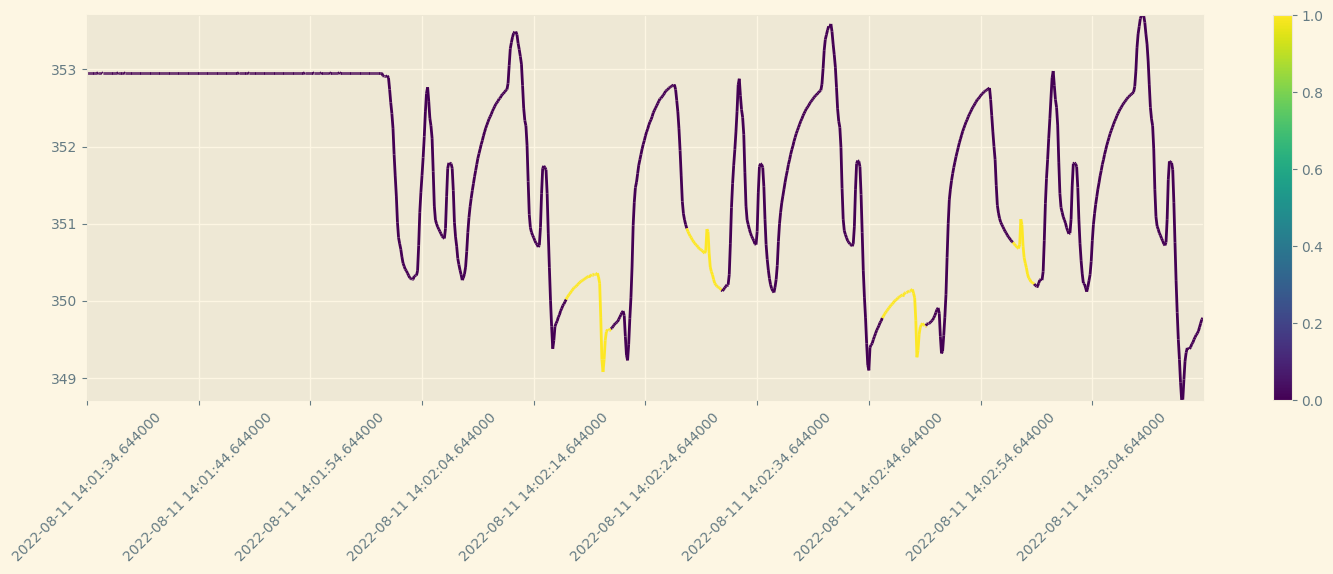

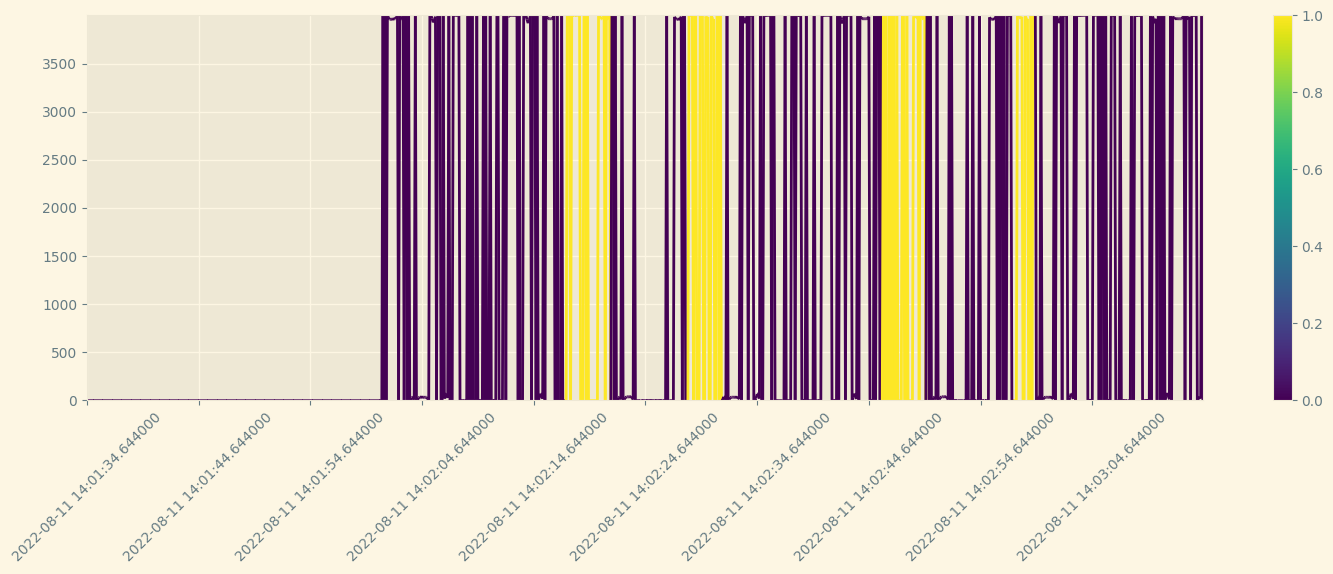

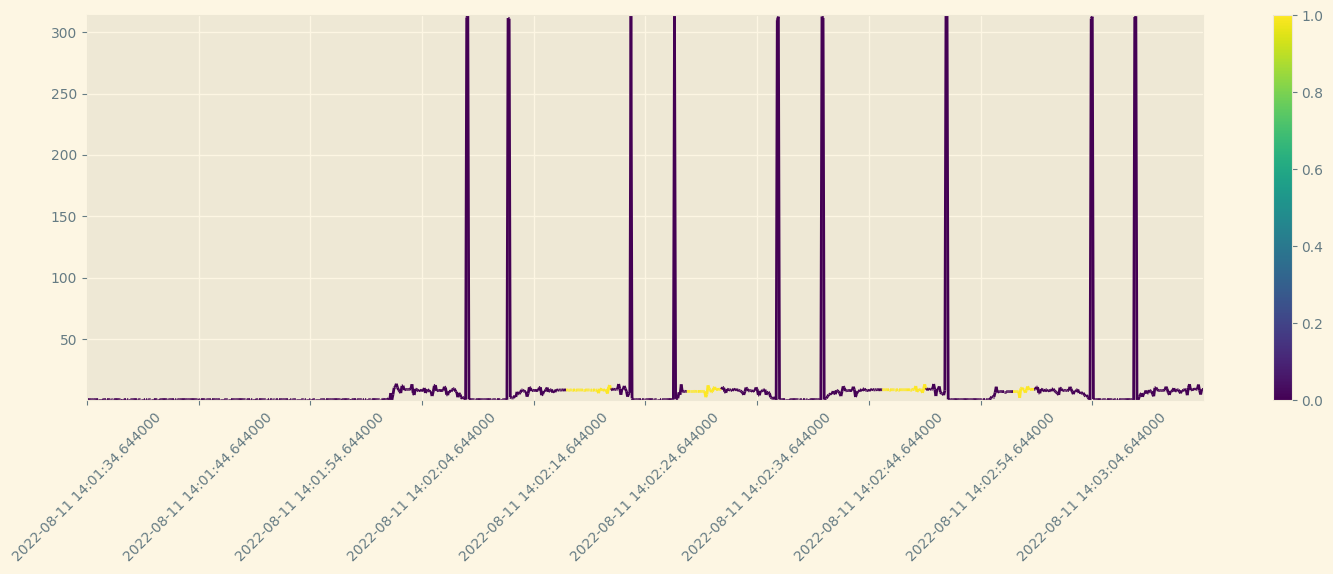

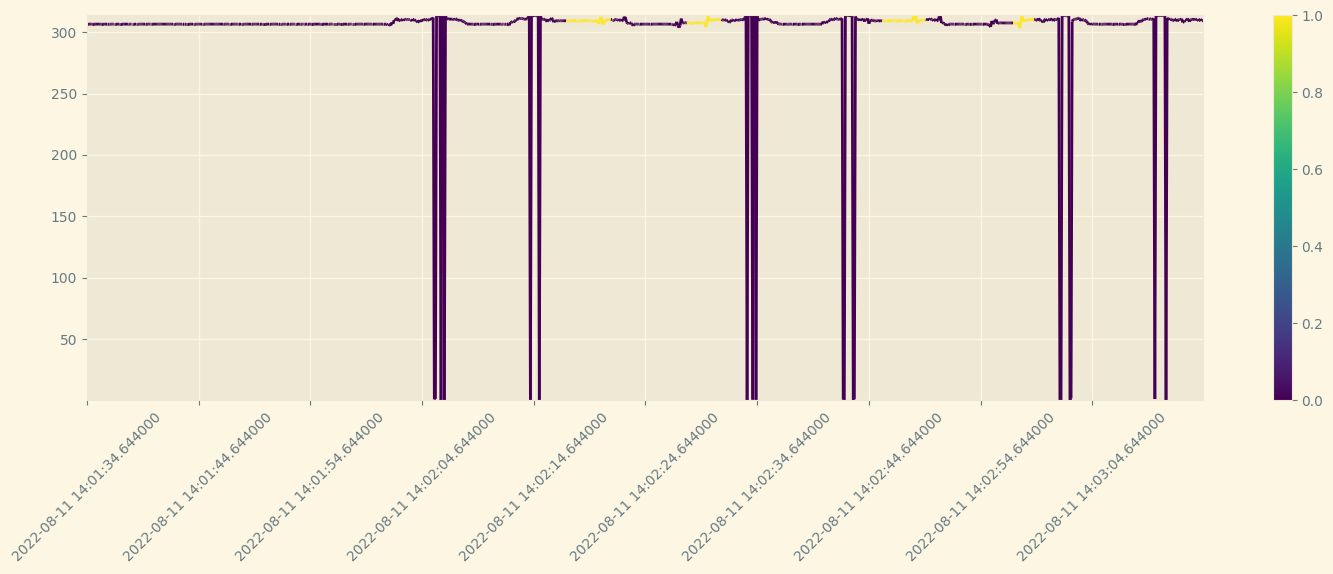

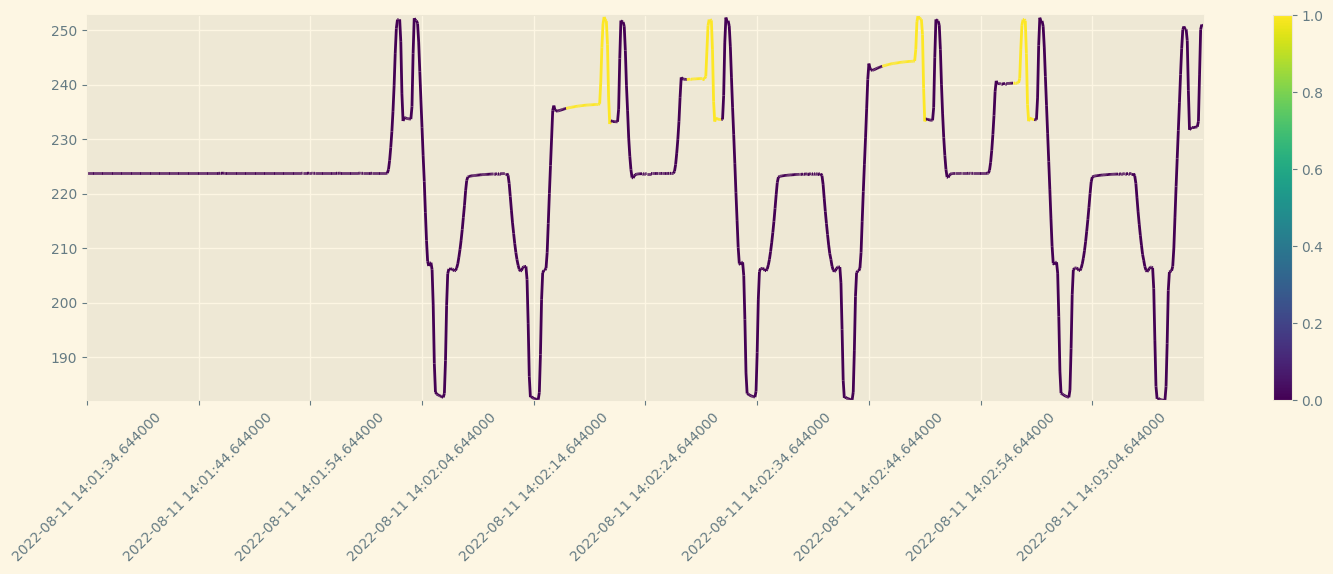

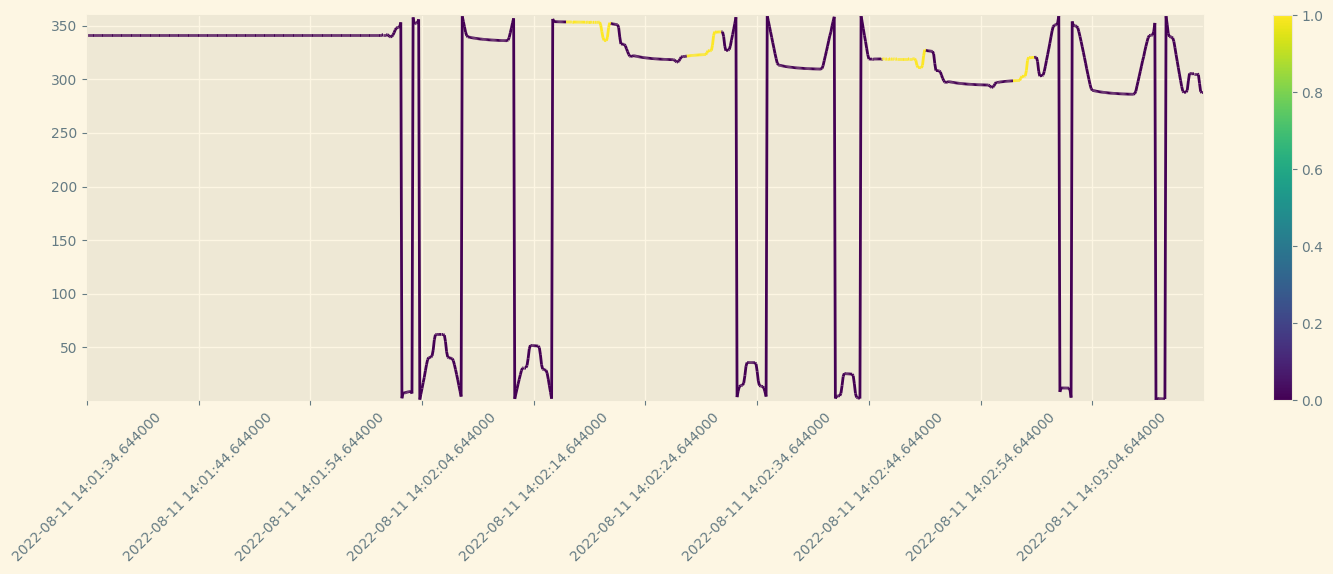

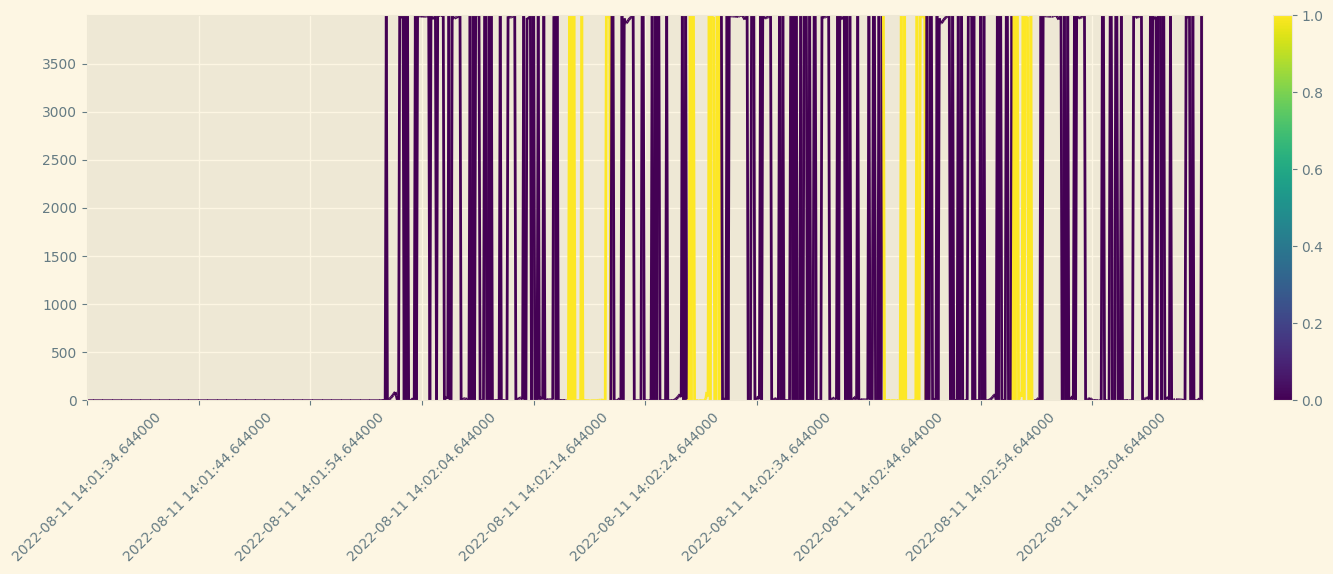

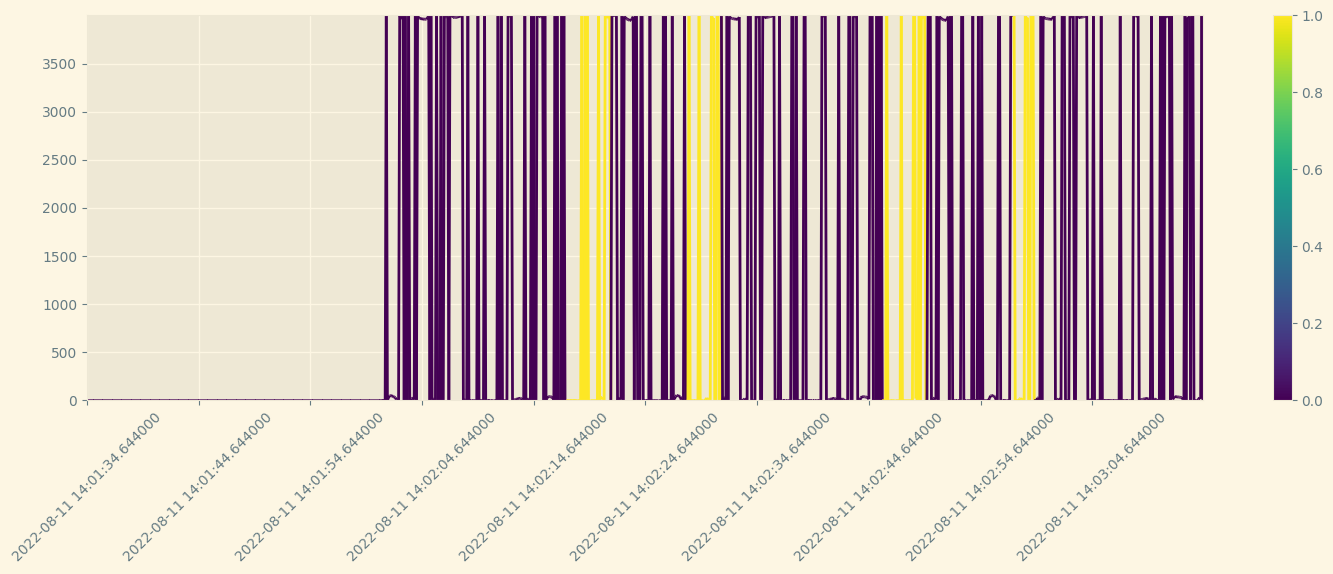

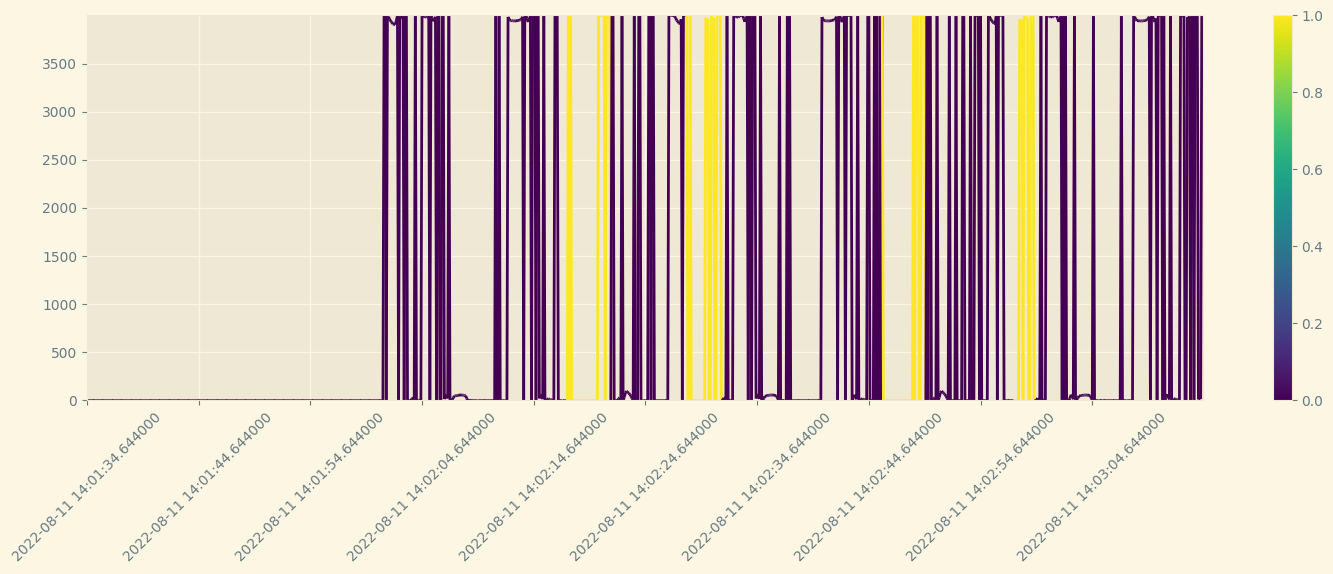

In [22]:
import matplotlib.pyplot as plt
import numpy as np


from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

def plot_anomaly_ts(index, data, anomaly_scores, title="Sensor_X", mapping=None, figsize=(18,5)):
    """
    Plots sensor data with anomalies highlighted in red and normal data in blue

    Args:
        index: range of values (in dataframe) to plot
        data: List or NumPy array of sensor readings.
        anomaly_scores: label or prediction of anomaly [0.0,1.0]
        title: Title for the plot (optional, defaults to "Sensor_X").
        mapping: due to incompatibilities of LineCollection ant timestamp data type we must perform a mapping later
    """

    # Separate normal and anomaly data for plotting

    x = np.array(index.copy()).reshape(-1,)
    y = np.array(data.copy()).reshape(-1,)
    dydx = np.array(anomaly_scores.copy()).reshape(-1,)[:-1]

    # Create a set of line segments so that we can color them individually
    # This creates the points as an N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True , figsize=figsize)

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(dydx.min(), dydx.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs)
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(y.min(), y.max())


    if mapping is not None:
        stride = len(mapping)//10
        plt.xticks(ticks=index[::stride],
                   labels=mapping[::stride],
                   rotation=45)  # Adjust rotation as needed

    plt.show()


def has_non_numeric_values(df, column_name):
    """
    Checks if a column in a pandas DataFrame contains non-numeric values.

    Args:
        df: The pandas DataFrame.
        column_name: The name of the column to check.

    Returns:
        True if the column contains non-numeric values, False otherwise.
    """

    return not pd.api.types.is_numeric_dtype(df[column_name])

def plot_all(df_anomaly, is_sorted=False, figsize=(18,5)):
    """
      plot all column (sensor values) in the dataframe,
      dataframe must have column anomaly
      remember to sort dataframe before passing
    """

    assert 'anomaly' in df_anomaly.keys(), "dataframe passed must have an anomaly label or anomaly score"
    assert is_sorted, "remember to sort and flag is_sorted=True"

    for key in df_anomaly.keys():
        if key == 'anomaly' or has_non_numeric_values(df_anomaly, key):
            continue
        plot_anomaly_ts(np.array([i for i in range(len(df_anomaly))]), df_anomaly[key], df_anomaly['anomaly'], title=key, mapping=df_anomaly.index)

# NOTE: remember to sort by index when calling head
plot_all(df_anomaly.sort_index().head(1000), is_sorted=True, figsize=(18,5))

In [ ]:

thresholds = np.sort(scores)
recalls, precisions, fprs, _, f1s, _, _ = metrics_by_window_vectorized(scores, thresholds, collision_times)
# Create tables with accumulated data
tableF1 = wandb.Table(columns=["threshold", "f1"])
tableROC = wandb.Table(columns=["fpr", "recall"])
tablePR = wandb.Table(columns=["recall","precision"])

decimate = len(scores)//100
#plot 1 sample every 100 for simplicity of graph on wandb

for i,(fpr, recall, precision) in enumerate(zip(fprs, recalls, precisions)):
    if i%decimate == 0:
        tableROC.add_data(fpr, recall) #ROC
        tablePR.add_data(recall, precision) #PRC

        
graphROC = wandb.plot.line(
    tableROC,  # Pass the table to the line plot function
    x="fpr",
    y="recall",
    title="ROC",
)
graphPRC = wandb.plot.line(
    tablePR,
    x="recall",
    y="precision",
    title="PRC"
)
wandb.log({
    'best F1': max(f1s),
    'ROC': graphROC,
    'PRC': graphPRC,
    'AUROC': calculate_auc(fprs, recalls),
    'AUPRC': calculate_auc(recalls, precisions)
})   